у нас есть урожайности фактическая и плановая. Можно посмотреть от чего зависит сальдо этих значений (буквально исследовательский вопрос: что влияет на неточность предсказаний урожайности?)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_fields = pd.read_csv('../data/fields.csv', delimiter=';', decimal=',', skiprows=[0, 2])
df_value = pd.read_csv('../data/value.csv', delimiter=';', decimal=',', skiprows=[0, 1], parse_dates=['inv_item_date'], date_format={'inv_item_date': '%d.%m.%Y'})
df_works = pd.read_csv('../data/works.csv', delimiter=';', decimal=',', skiprows=[0, 1], parse_dates=['start_date', 'end_date'], date_format={'start_date': '%d.%m.%Y', 'end_date': '%d.%m.%Y'})

df_works['area'] = df_works['area'].str.replace(',', '.').astype(float)

In [3]:
df_value[df_value['inv_item_type'] == 'Удобрения']['inv_item_name'].value_counts()

inv_item_name
Удобрение 57    10275
Удобрение 10     7440
Удобрение 49     4600
Удобрение 38     4308
Удобрение 15     3188
                ...  
Удобрение 27        1
Удобрение 51        1
Удобрение 61        1
Удобрение 71        1
Удобрение 74        1
Name: count, Length: 68, dtype: int64

In [4]:
valid_work_subtypes = ['Прямое комбайнирование', 'Подбор и обмолот', 'Заготовка сенажа', 'Уборка силос/карнаж', 'Подбор (корм)', 'Вывоз', 'Прессование']
valid_work_types = ['Обработка почвы', 'Уборка']

df_yield_fact_works = df_works.query(
    f"work_type in {valid_work_types} and work_subtype in {valid_work_subtypes}"
)[['season', 'field', 'yield_fact', 'area', 'work_type']]

df_yield_fact = (
    df_yield_fact_works
    .assign(weighted_yield=lambda x: x['yield_fact'] * x['area'])
    .groupby(['field', 'season'])
    .agg(weighted_yield=('weighted_yield', 'sum'), total_area=('area', 'sum'))
    .assign(weighted_mean=lambda x: x['weighted_yield'] / x['total_area'])
    .reset_index()[['field', 'season', 'weighted_mean']]
)

df_yield_fact = df_yield_fact.rename(columns={'weighted_mean': 'yield_fact'})

df_yield_fact.head()

field  season  yield_fact
0  02.09.02.002.01    2023    1.568170
1  02.09.02.002.01    2024    0.000000
2  02.09.02.015.00    2023    1.223696
3  02.09.02.019.00    2023    2.150000
4  02.09.03.032.00    2023  268.696209

In [5]:
df_fields.shape

(16060, 19)

In [6]:
df_fields_tmp = df_fields[['season', 'field', 'p2o5', 'k2o', 'humus', 'ph', 'crop', 'region', 'yield_plan']]
df_fields_tmp.head()

df = df_fields_tmp.merge(df_yield_fact, how='left', on=['field', 'season']) #.dropna(subset=['yield_fact', 'yield_plan'])

df.head()

season            field    p2o5    k2o  humus    ph               crop  \
0    2023  22.47.01.001.01  221.05  206.3   4.05  5.25  Оз.пшеница мягкая   
1    2023  22.47.01.001.02  221.05  206.3   4.05  5.25                Пар   
2    2023  22.47.01.002.00  199.80  186.0   3.50  5.20                Пар   
3    2023  22.47.01.003.00  186.50  174.8   5.90  5.40  Оз.пшеница мягкая   
4    2023  22.47.01.004.00  166.60  147.9   5.60  5.40  Оз.пшеница мягкая   

  region  yield_plan  yield_fact  
0  Алтай         3.8  190.592405  
1  Алтай         NaN         NaN  
2  Алтай         NaN         NaN  
3  Алтай         3.8    1.851617  
4  Алтай         3.8    1.418186

In [7]:
df.shape

(16060, 10)

In [8]:
df.isna().sum()

season           0
field            0
p2o5          5750
k2o           5743
humus         5788
ph            5742
crop             0
region           0
yield_plan    5205
yield_fact    6573
dtype: int64

In [9]:
df = df.dropna()

In [10]:
df.shape

(7324, 10)

In [11]:
df['fact_plan_dif'] = df['yield_fact'] - df['yield_plan']
df['fact_plan_dif_abs'] = abs(df['fact_plan_dif'])
df['fact_plan_div'] = df['fact_plan_dif'] / df['yield_plan']
df['fact_plan_share_dif'] = df['yield_fact'] / df['yield_plan'] - 1

In [12]:
df.head()

season            field    p2o5    k2o  humus    ph               crop  \
0    2023  22.47.01.001.01  221.05  206.3   4.05  5.25  Оз.пшеница мягкая   
3    2023  22.47.01.003.00  186.50  174.8   5.90  5.40  Оз.пшеница мягкая   
4    2023  22.47.01.004.00  166.60  147.9   5.60  5.40  Оз.пшеница мягкая   
7    2023  22.47.01.006.02  194.70  195.9   4.00  5.15  Оз.пшеница мягкая   
9    2023  22.47.01.007.02  184.20  171.4   4.40  5.05  Оз.пшеница мягкая   

  region  yield_plan  yield_fact  fact_plan_dif  fact_plan_dif_abs  \
0  Алтай         3.8  190.592405     186.792405         186.792405   
3  Алтай         3.8    1.851617      -1.948383           1.948383   
4  Алтай         3.8    1.418186      -2.381814           2.381814   
7  Алтай         3.8    2.187347      -1.612653           1.612653   
9  Алтай         3.8    2.109071      -1.690929           1.690929   

   fact_plan_div  fact_plan_share_dif  
0      49.155896            49.155896  
3      -0.512732            -0.512732  
4      -0.626793            -0.626793  
7      -0.424382            -0.424382  
9      -0.444981            -0.444981

<Axes: >

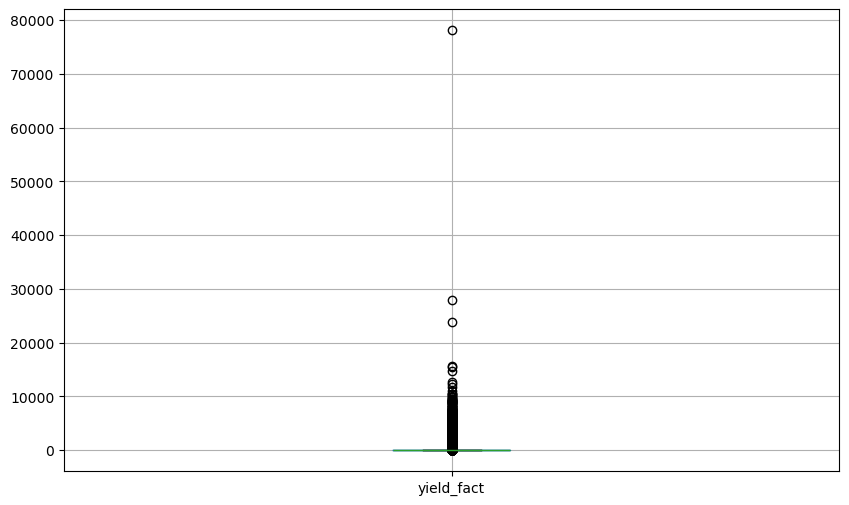

In [13]:
df.boxplot(column=['yield_fact'], figsize=(10, 6))

In [14]:
def remove_outliers_iqr(df, column, k = 1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [15]:
df = remove_outliers_iqr(df, 'yield_fact', k=1.5)

In [16]:
df.shape

(6759, 14)

In [17]:
df.boxplot(column=['yield_fact'], figsize=(10, 6))

<Axes: >

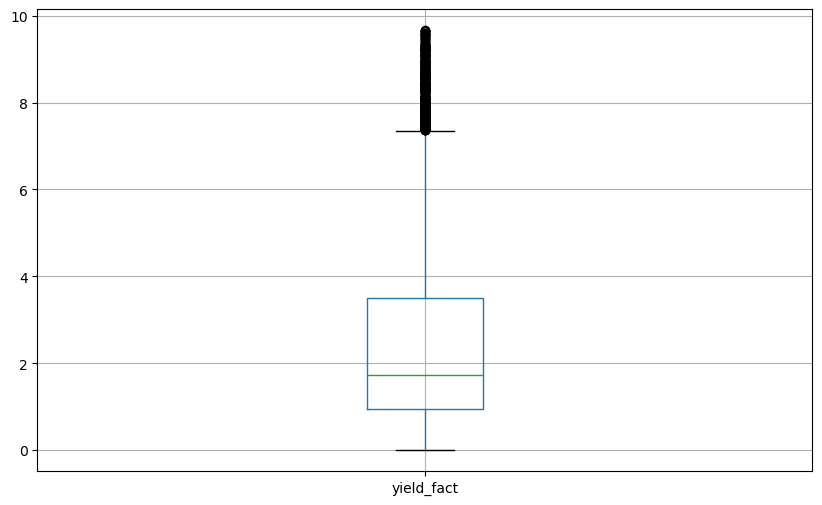

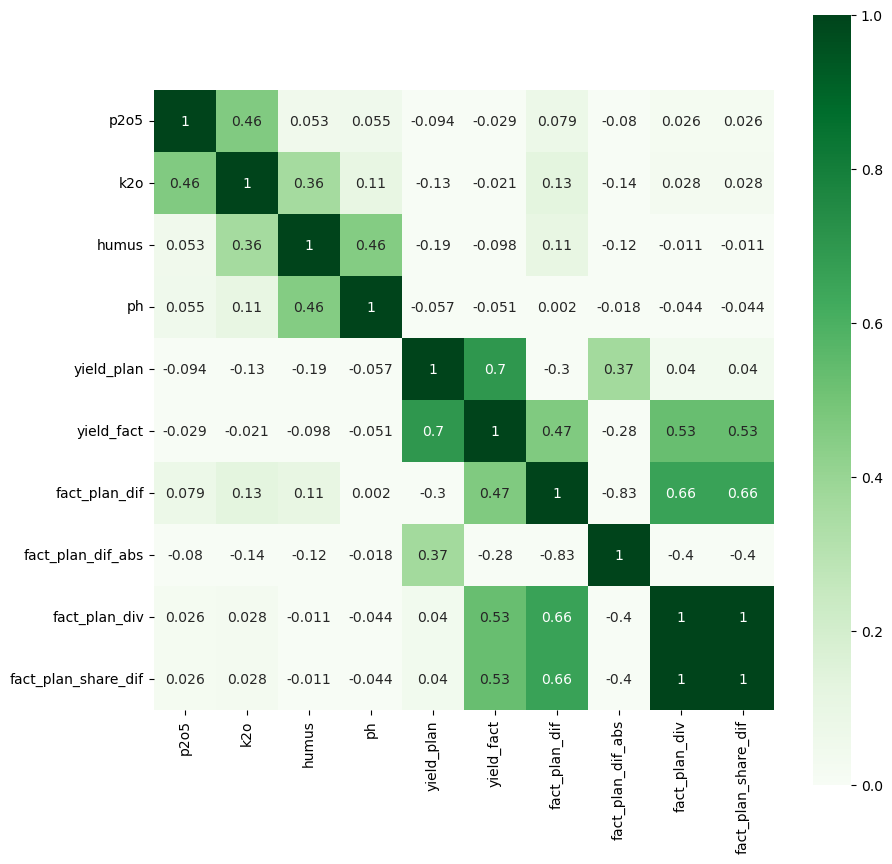

In [18]:
plt.figure(figsize=(10, 10))

corrs = df.drop(['season', 'field', 'crop', 'region'], axis=1).corr().round(3)
sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0,
            annot=True)

plt.show()

In [19]:
top_crops = df['crop'].value_counts().head(5).index.to_list()
top_crops

['Кукуруза силос',
 'Люцерна пр.лет корм',
 'Оз.пшеница мягкая',
 'Соя',
 'Яр.пшеница мягкая']

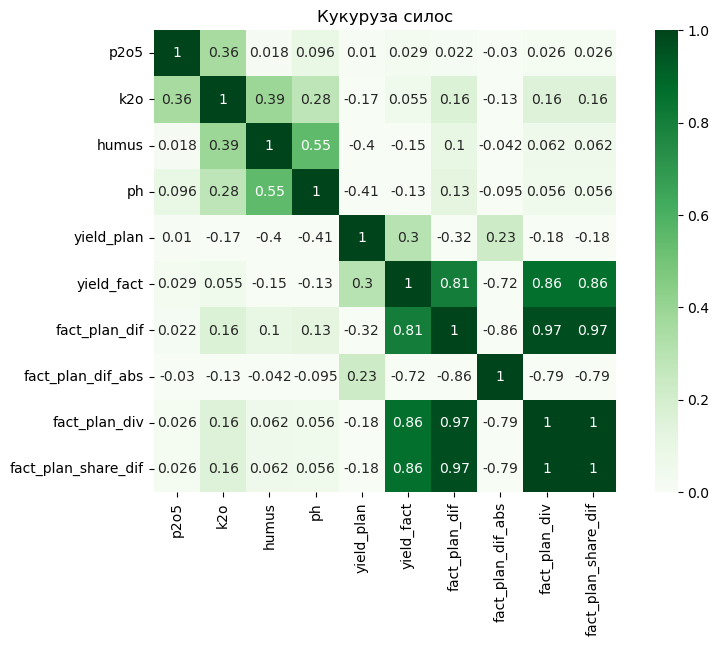

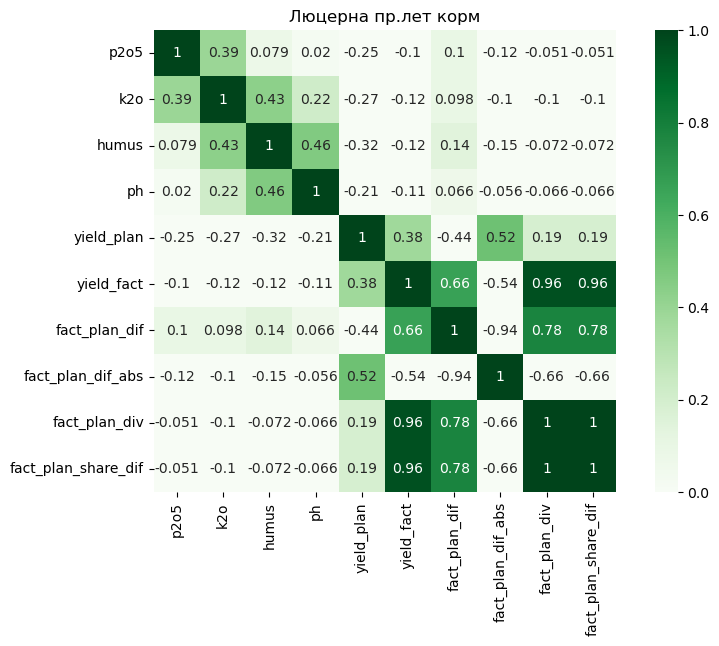

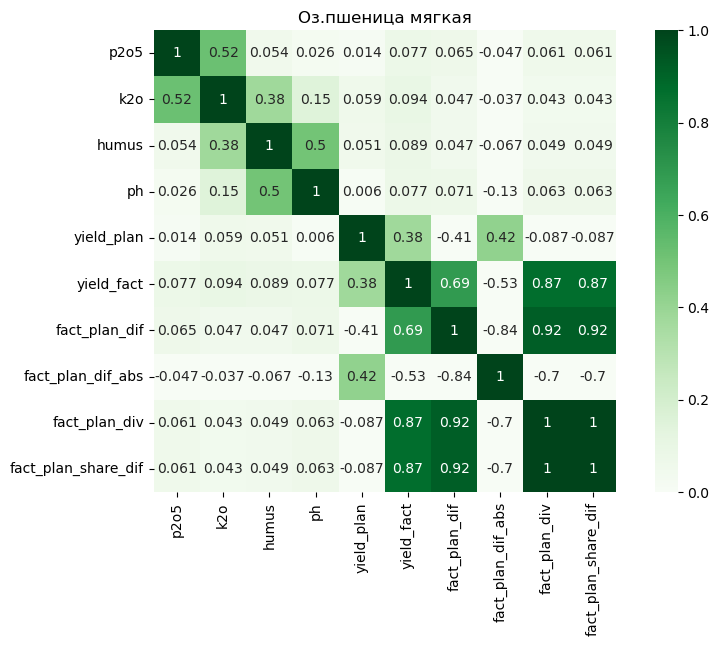

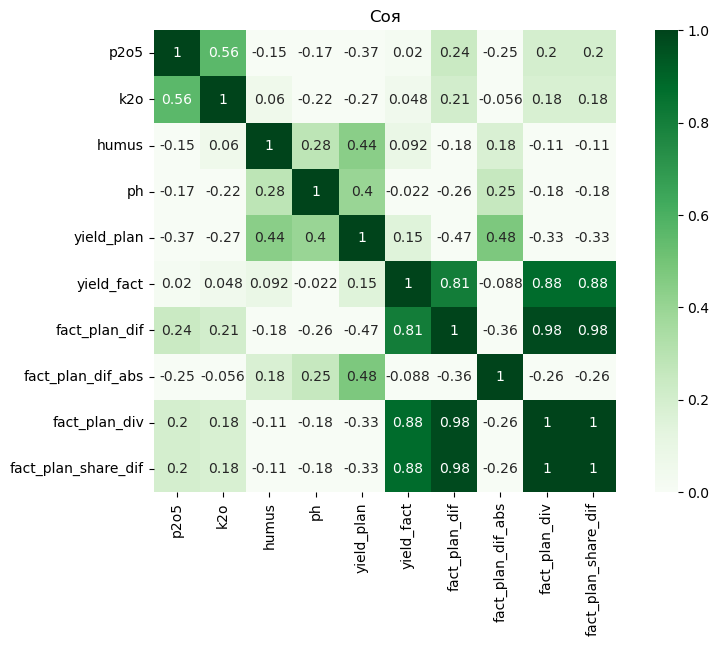

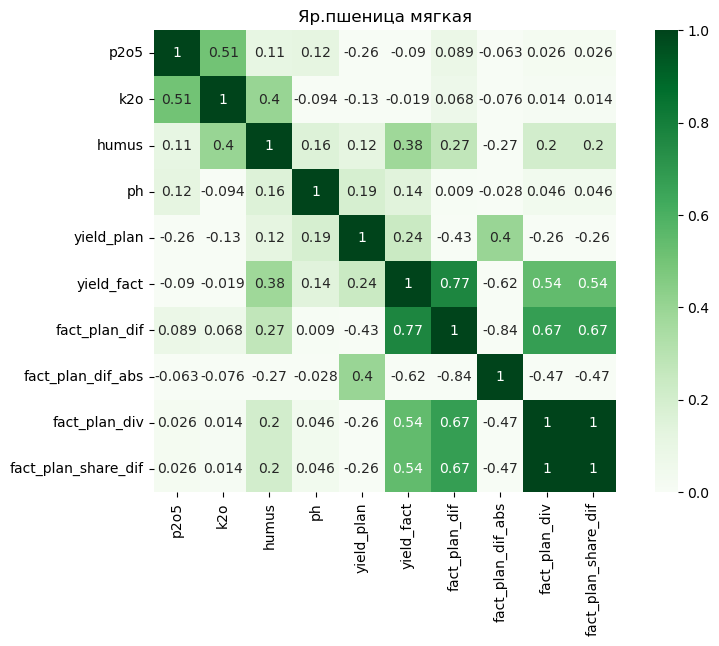

In [20]:
for crop in top_crops:
    plt.figure(figsize=(10, 6))

    df_crop = df.query(f"crop == '{crop}'")

    corrs = df_crop.drop(['season', 'field', 'crop', 'region'], axis=1).corr().round(3)
    sns.heatmap(corrs,
                cmap = 'Greens',
                square=True,
                vmin = 0,
                annot=True)

    plt.title(f'{crop}')
    plt.show()

plt.close()

In [21]:
top_regions = df['region'].value_counts().head(5).index.to_list()
top_regions

['Воронеж', 'Калуга', 'Рязань', 'Курск', 'Татарстан']

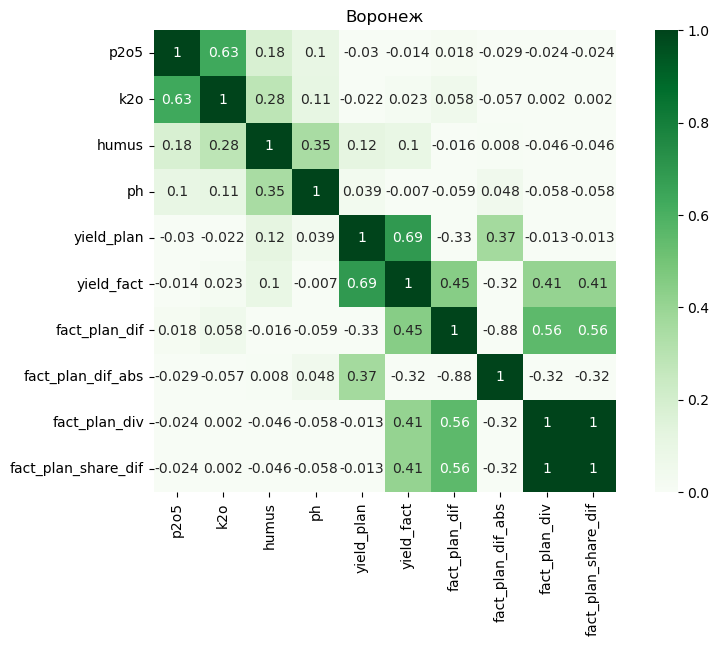

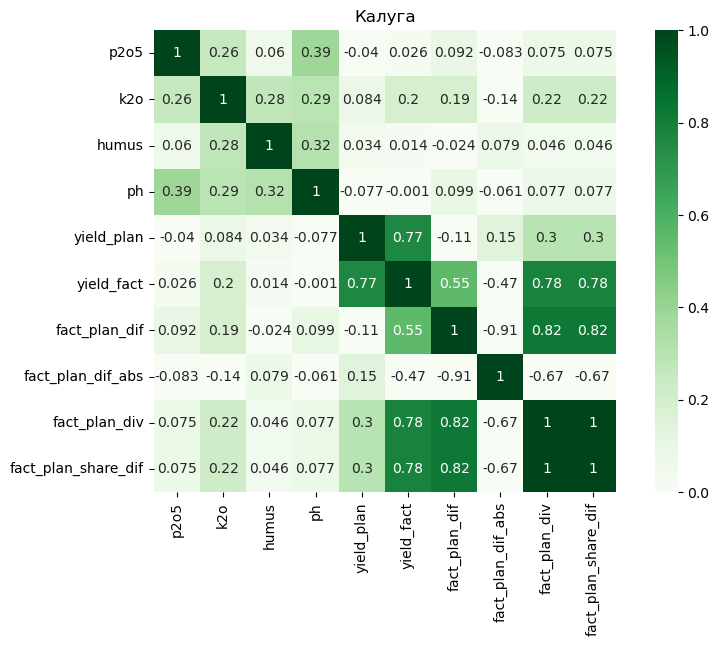

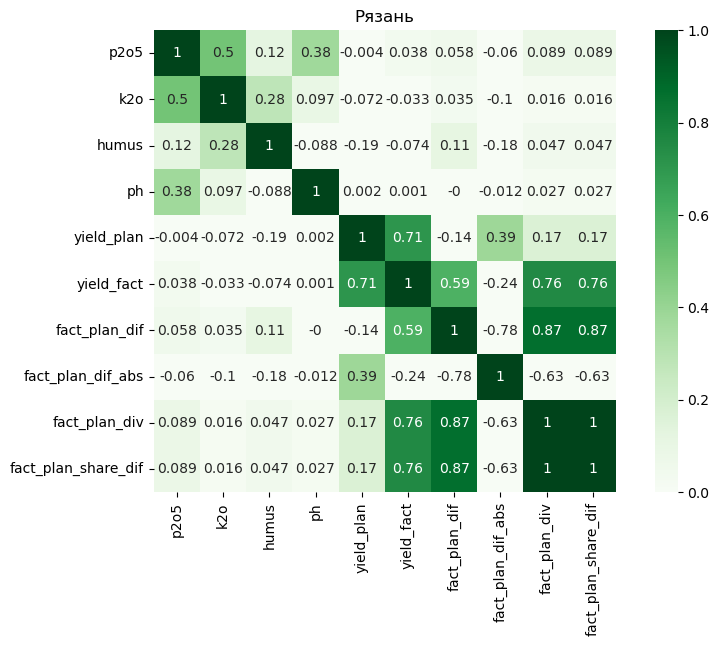

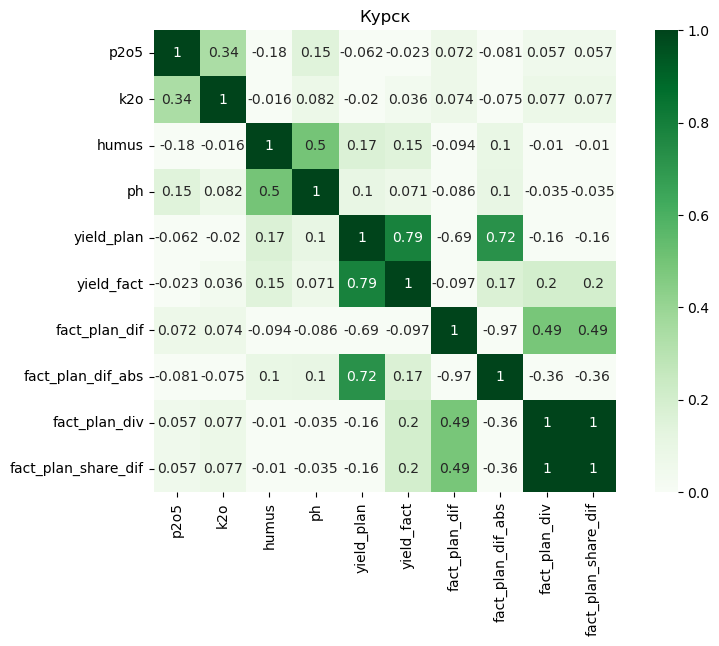

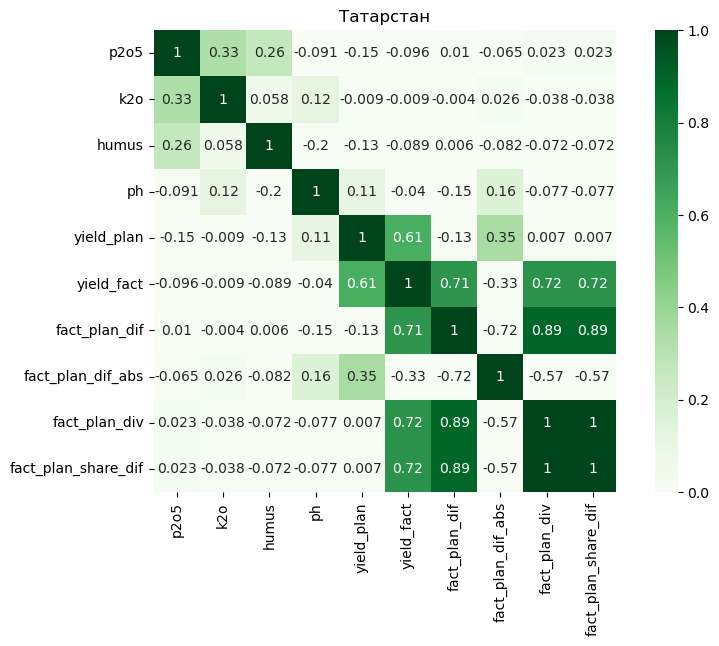

In [22]:
for region in top_regions:
    plt.figure(figsize=(10, 6))

    df_region = df.query(f"region == '{region}'")

    corrs = df_region.drop(['season', 'field', 'crop', 'region'], axis=1).corr().round(3)
    sns.heatmap(corrs,
                cmap = 'Greens',
                square=True,
                vmin = 0,
                annot=True)

    plt.title(f'{region}')
    plt.show()

plt.close()

In [23]:
df.head()

season            field   p2o5    k2o  humus    ph               crop  \
3     2023  22.47.01.003.00  186.5  174.8    5.9  5.40  Оз.пшеница мягкая   
4     2023  22.47.01.004.00  166.6  147.9    5.6  5.40  Оз.пшеница мягкая   
7     2023  22.47.01.006.02  194.7  195.9    4.0  5.15  Оз.пшеница мягкая   
9     2023  22.47.01.007.02  184.2  171.4    4.4  5.05  Оз.пшеница мягкая   
10    2023  22.47.01.008.00  249.0  151.5    3.7  5.20  Оз.пшеница мягкая   

   region  yield_plan  yield_fact  fact_plan_dif  fact_plan_dif_abs  \
3   Алтай         3.8    1.851617      -1.948383           1.948383   
4   Алтай         3.8    1.418186      -2.381814           2.381814   
7   Алтай         3.8    2.187347      -1.612653           1.612653   
9   Алтай         3.8    2.109071      -1.690929           1.690929   
10  Алтай         3.8    2.030000      -1.770000           1.770000   

    fact_plan_div  fact_plan_share_dif  
3       -0.512732            -0.512732  
4       -0.626793            -0.626793  
7       -0.424382            -0.424382  
9       -0.444981            -0.444981  
10      -0.465789            -0.465789

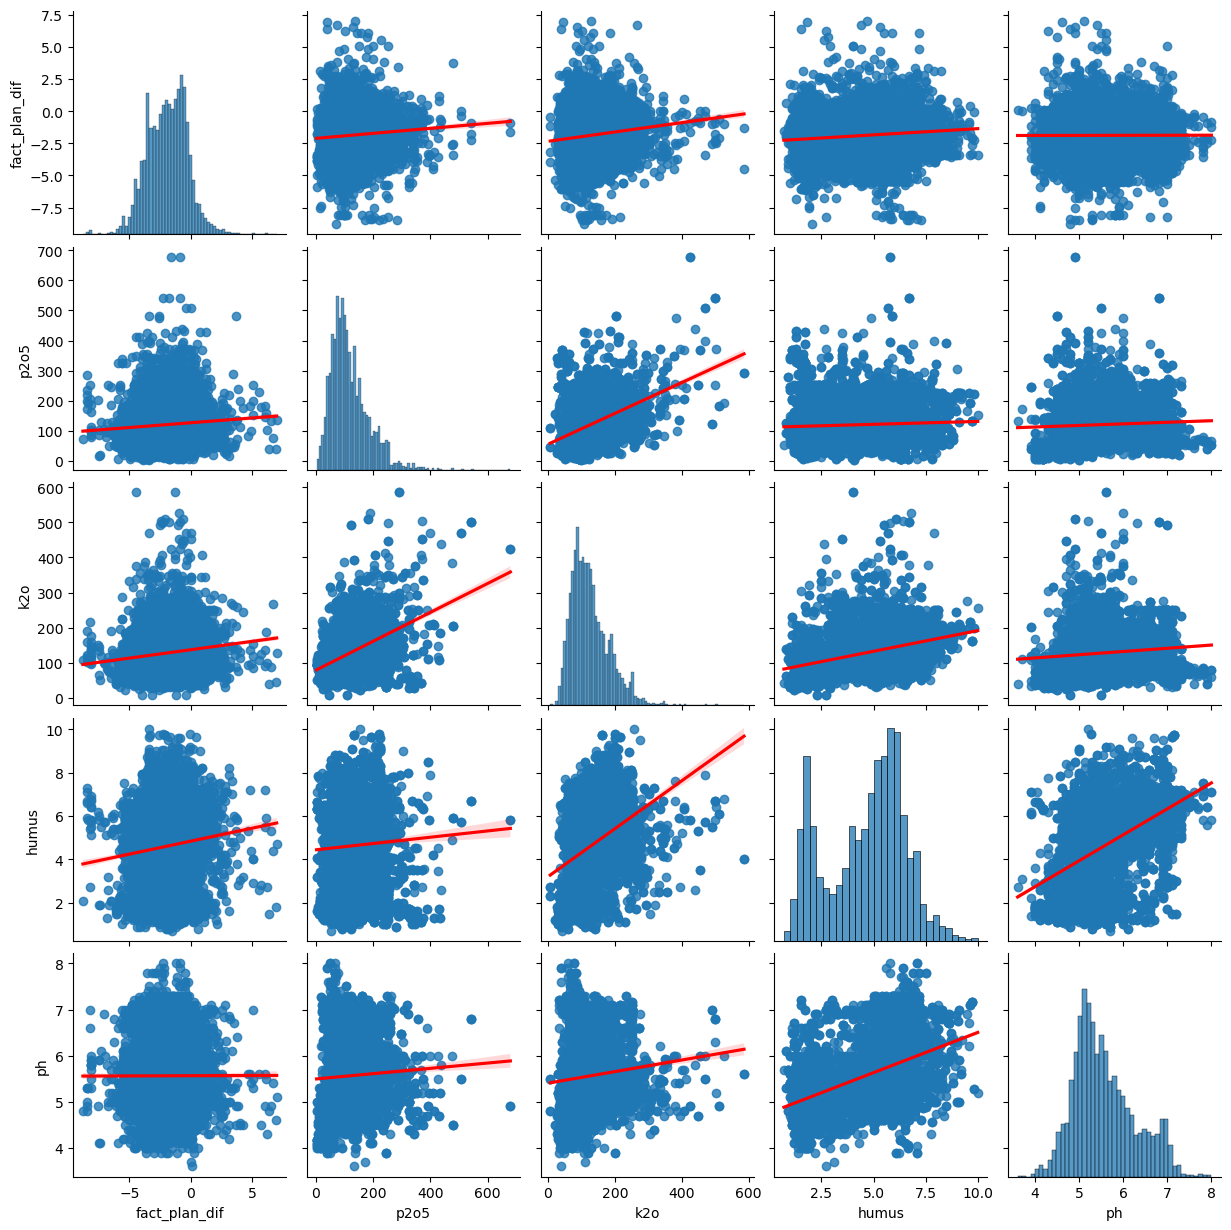

In [24]:
# Диаграммы рассеяния
sns.pairplot(data=df, vars=['fact_plan_dif', 'p2o5', 'k2o', 'humus', 'ph'], kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()


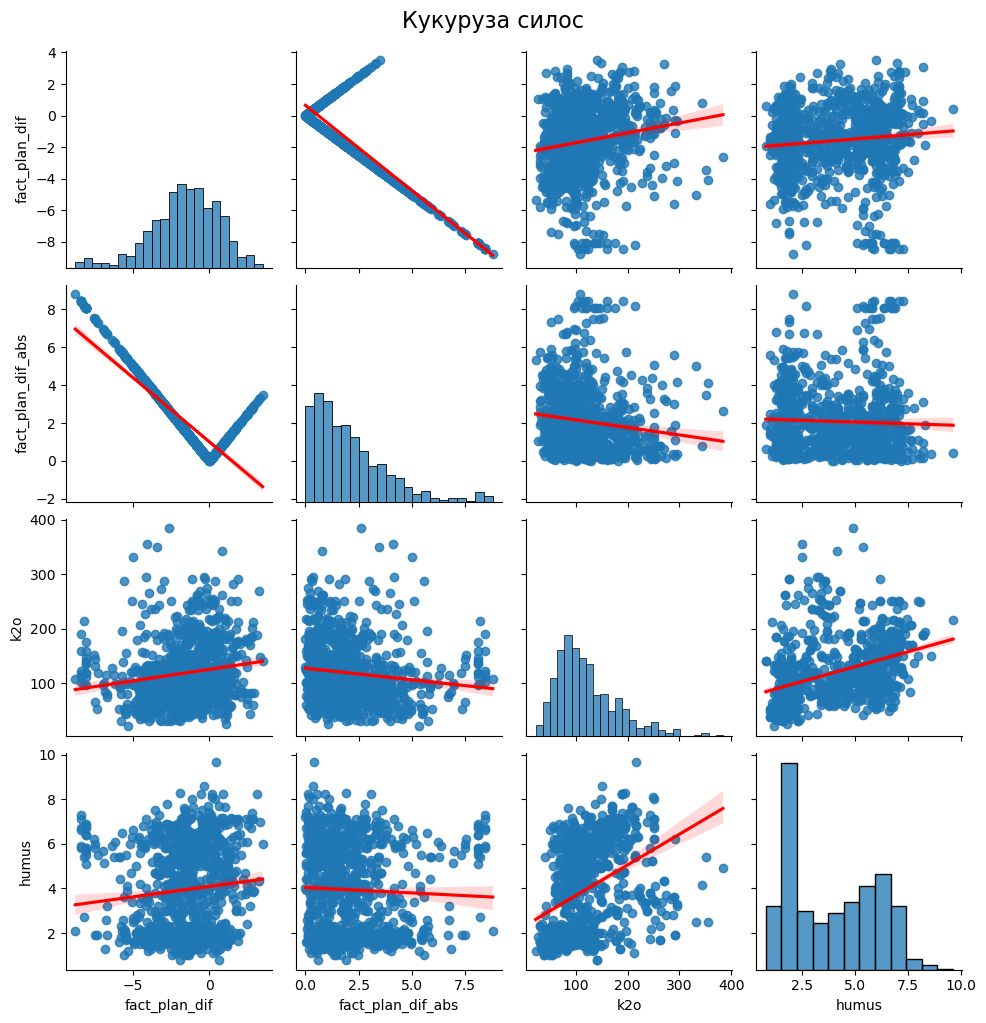

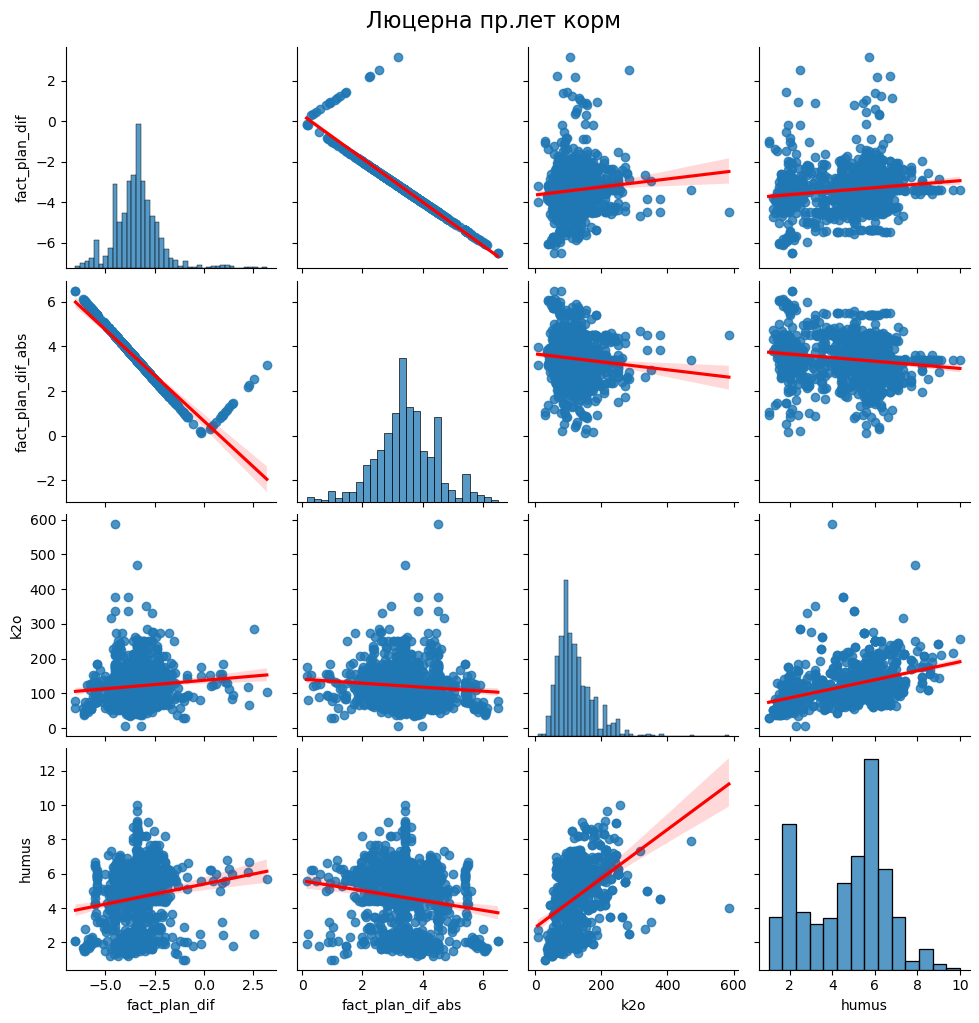

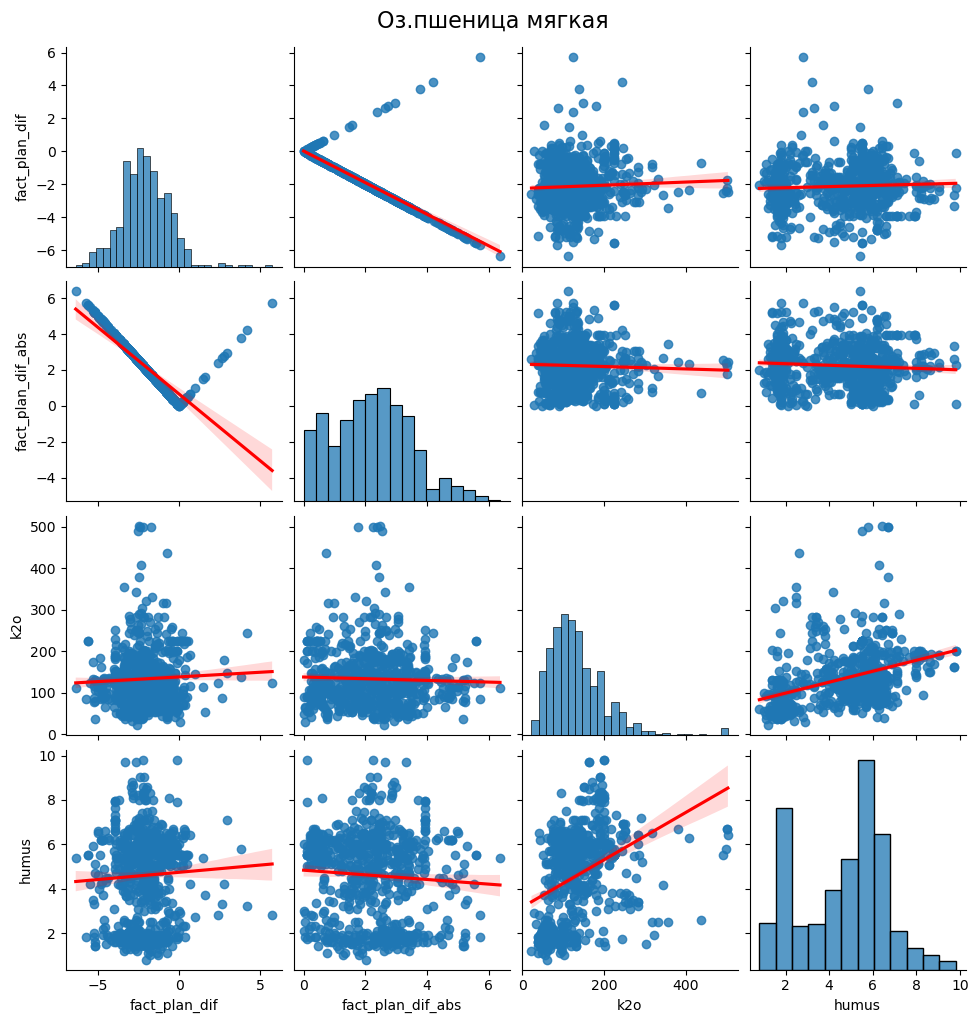

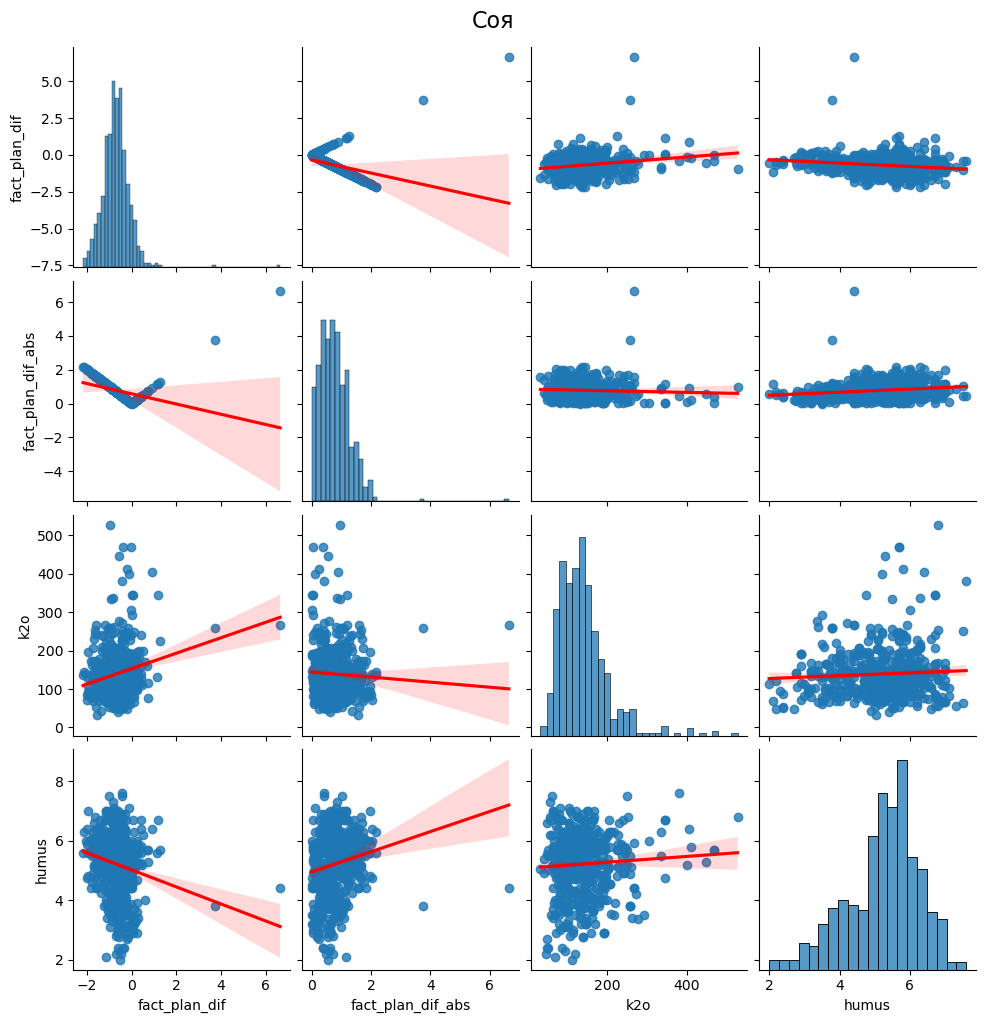

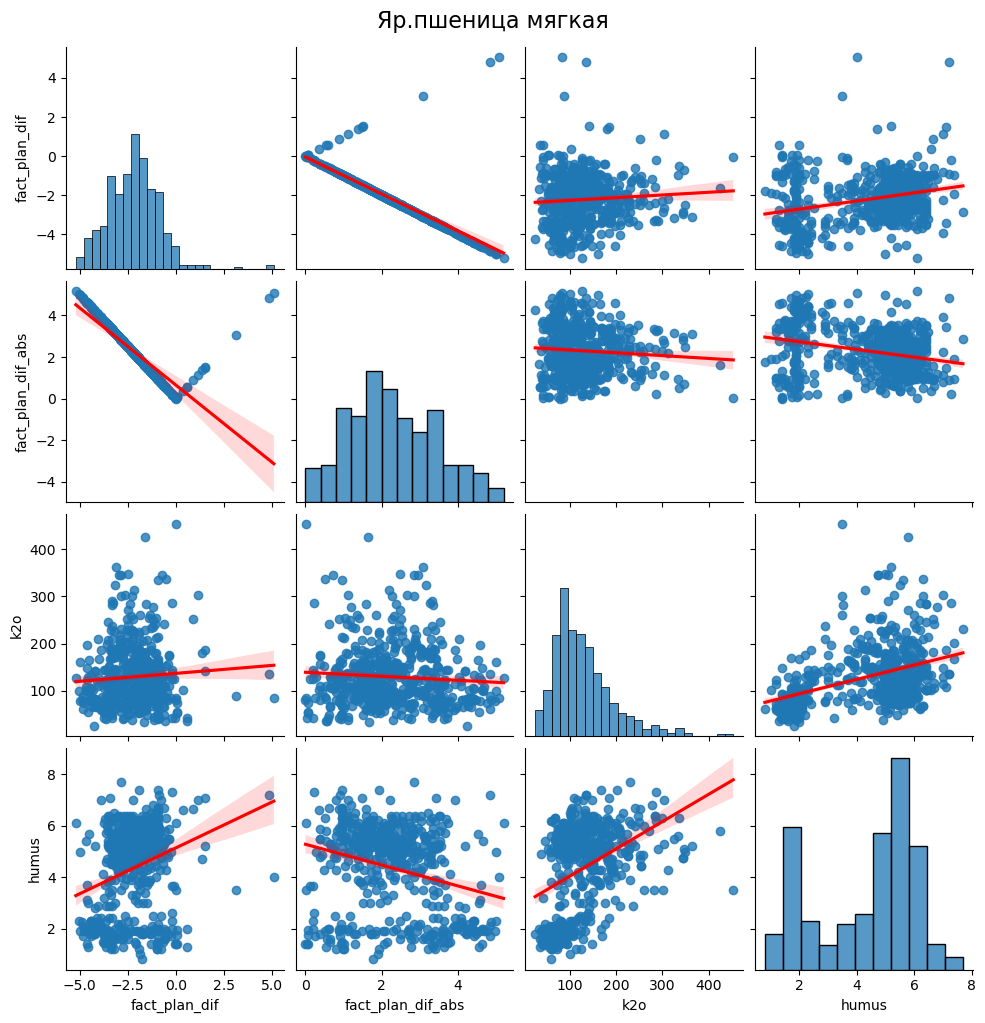

In [25]:
for crop in top_crops:
    # plt.figure(figsize=(10, 6))

    df_crop = df.query(f"crop == '{crop}'")

    sns.pairplot(
        data=df_crop,
        vars=['fact_plan_dif', 'fact_plan_dif_abs', 'k2o', 'humus'],
        kind='reg',
        plot_kws={'line_kws':{'color':'red'}})
    
    plt.suptitle(f'{crop}', y=1.02, fontsize=16)

    plt.show()

plt.close()

<Figure size 1000x600 with 0 Axes>

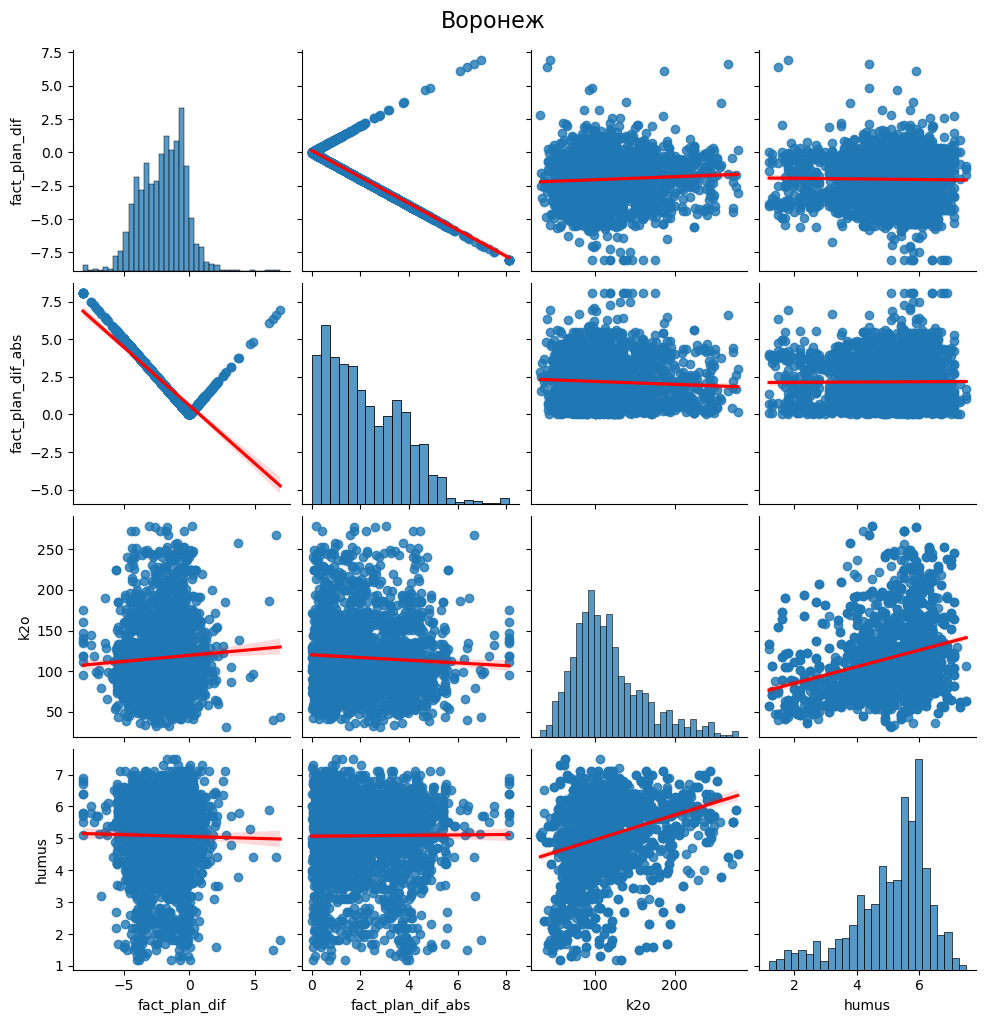

<Figure size 1000x600 with 0 Axes>

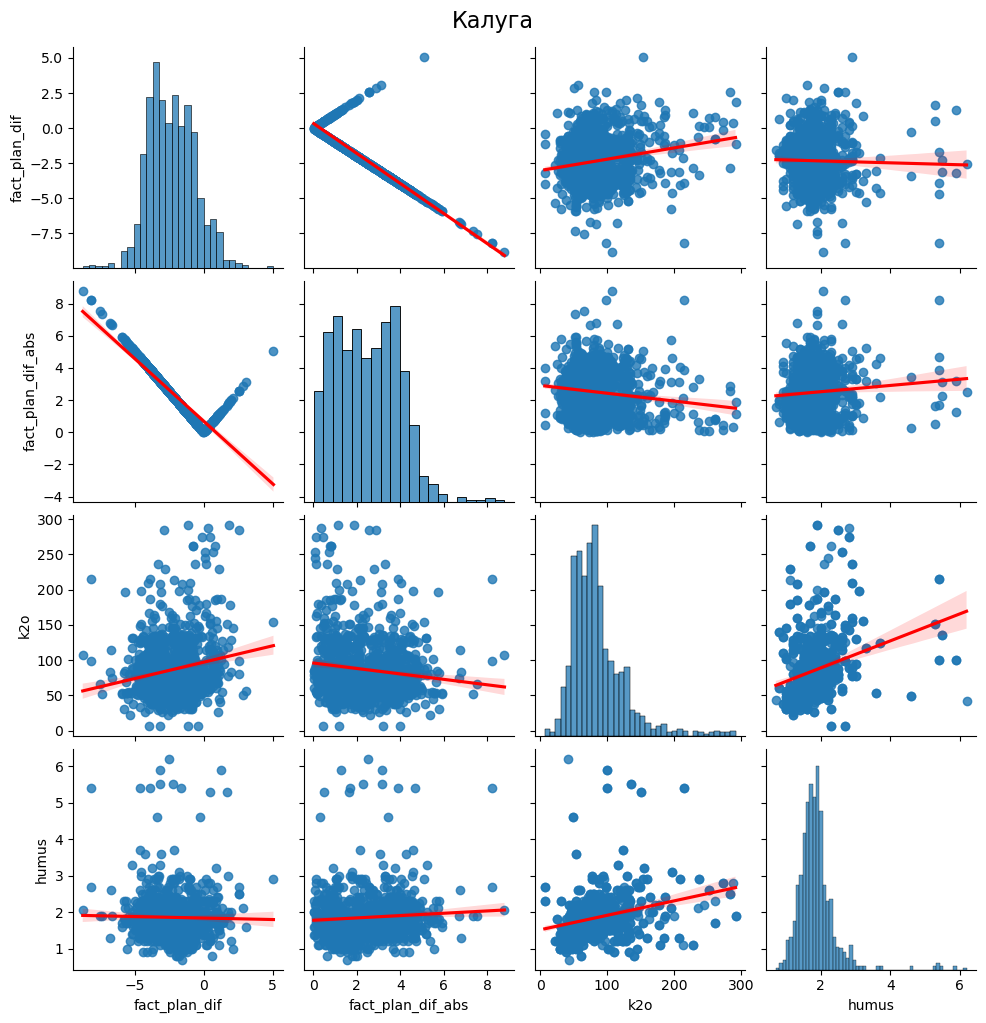

<Figure size 1000x600 with 0 Axes>

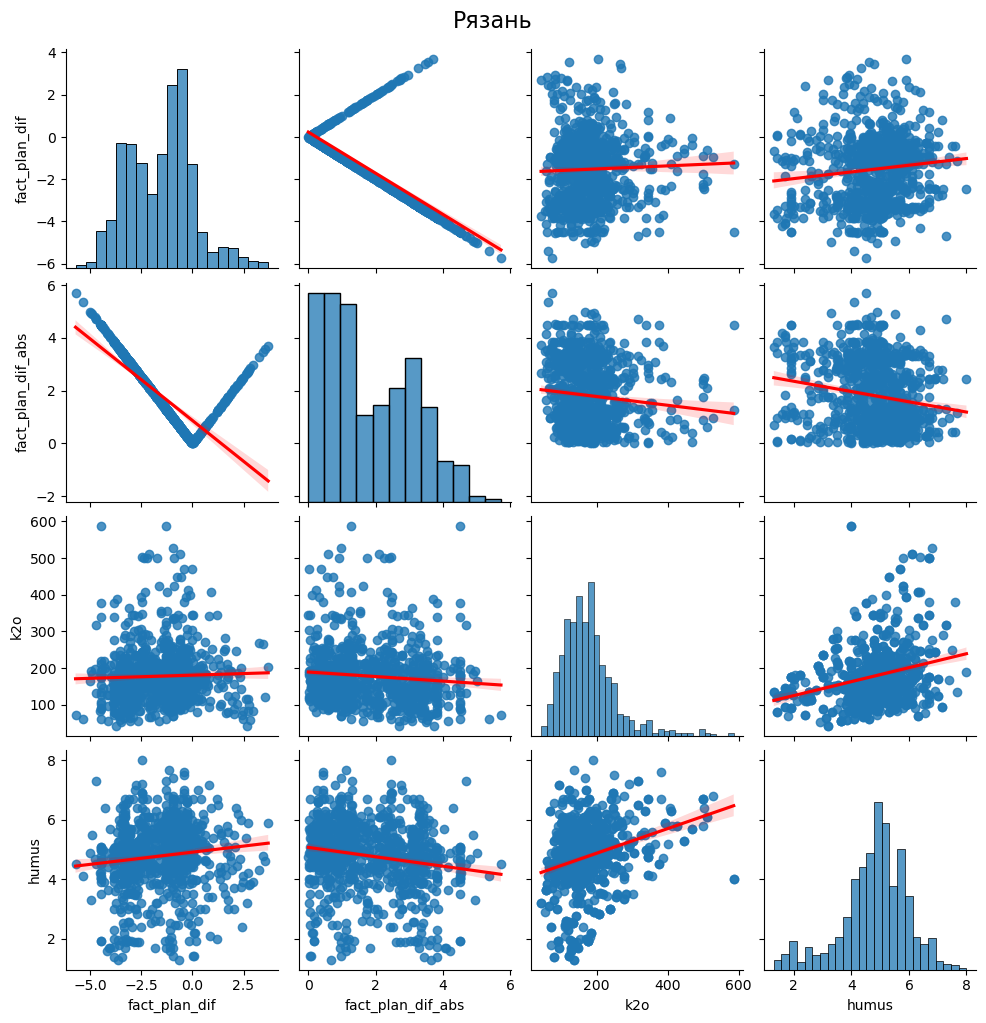

<Figure size 1000x600 with 0 Axes>

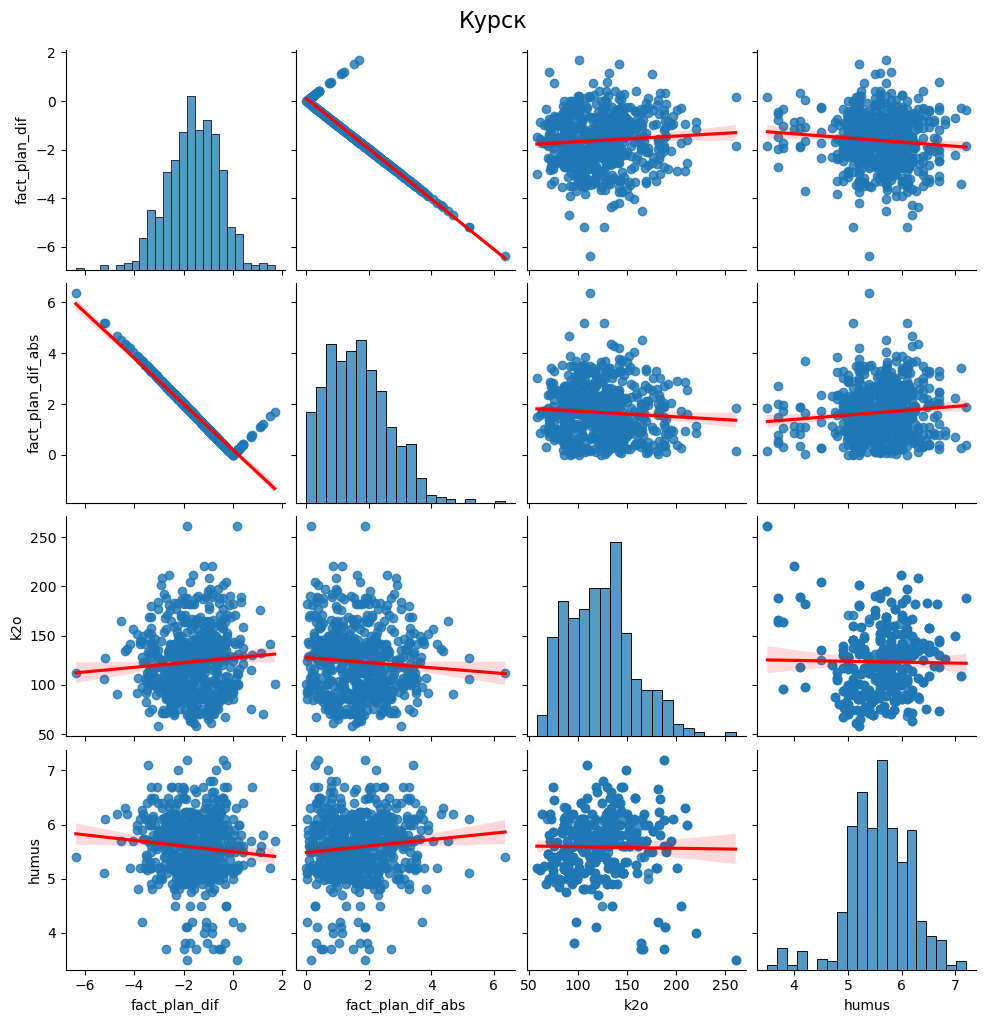

<Figure size 1000x600 with 0 Axes>

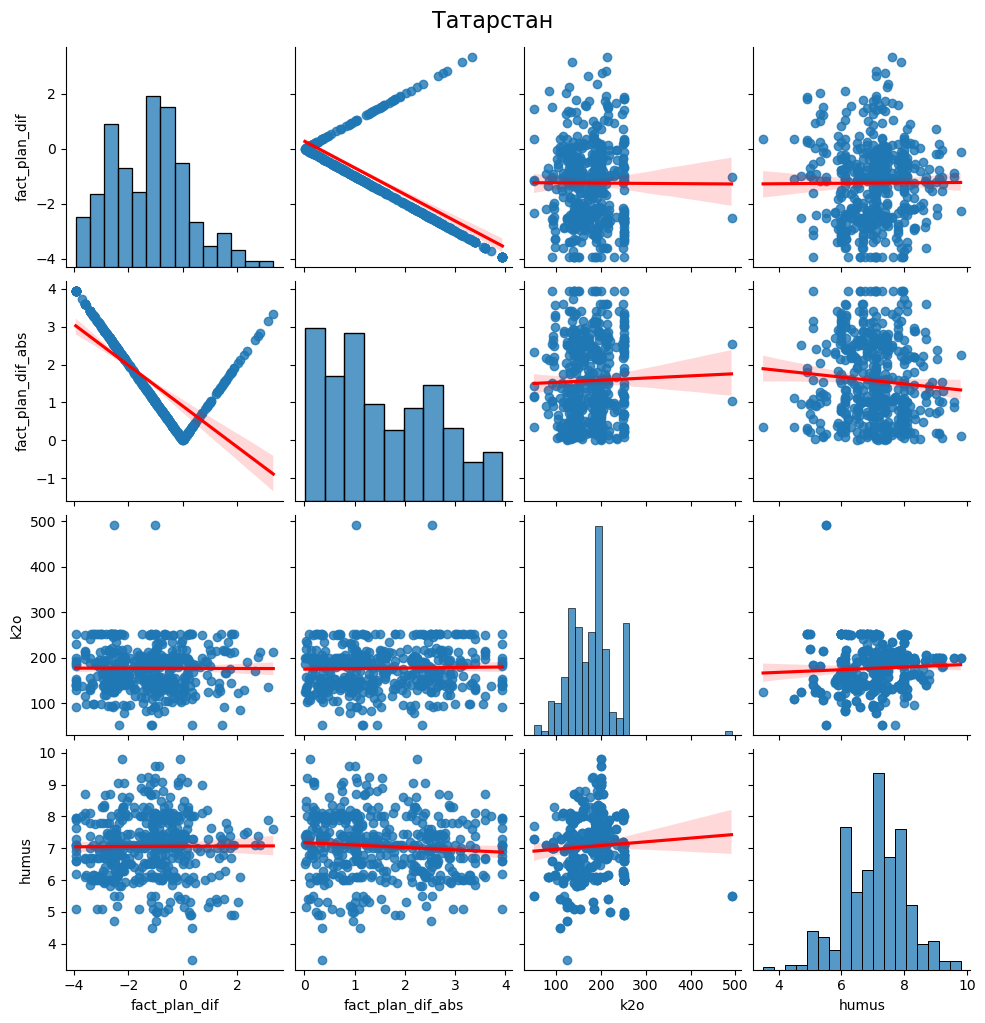

In [26]:
for region in top_regions:
    plt.figure(figsize=(10, 6))

    df_region = df.query(f"region == '{region}'")

    sns.pairplot(
        data=df_region,
        vars=['fact_plan_dif', 'fact_plan_dif_abs', 'k2o', 'humus'],
        kind='reg',
        plot_kws={'line_kws':{'color':'red'}})
    
    plt.suptitle(f'{region}', y=1.02, fontsize=16)

    plt.show()

plt.close()

In [27]:
df.to_csv('../data/fact_plan.csv', index=False)

<Figure size 1000x600 with 0 Axes>

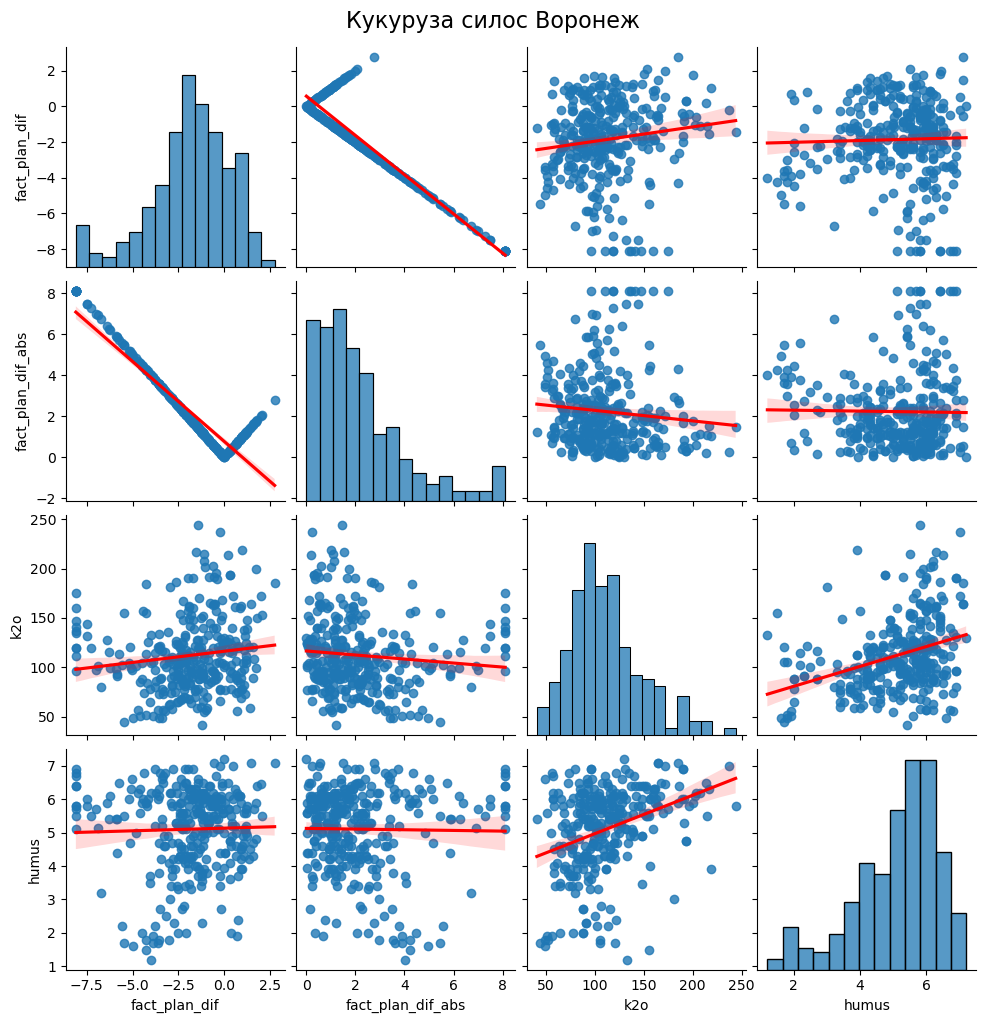

<Figure size 1000x600 with 0 Axes>

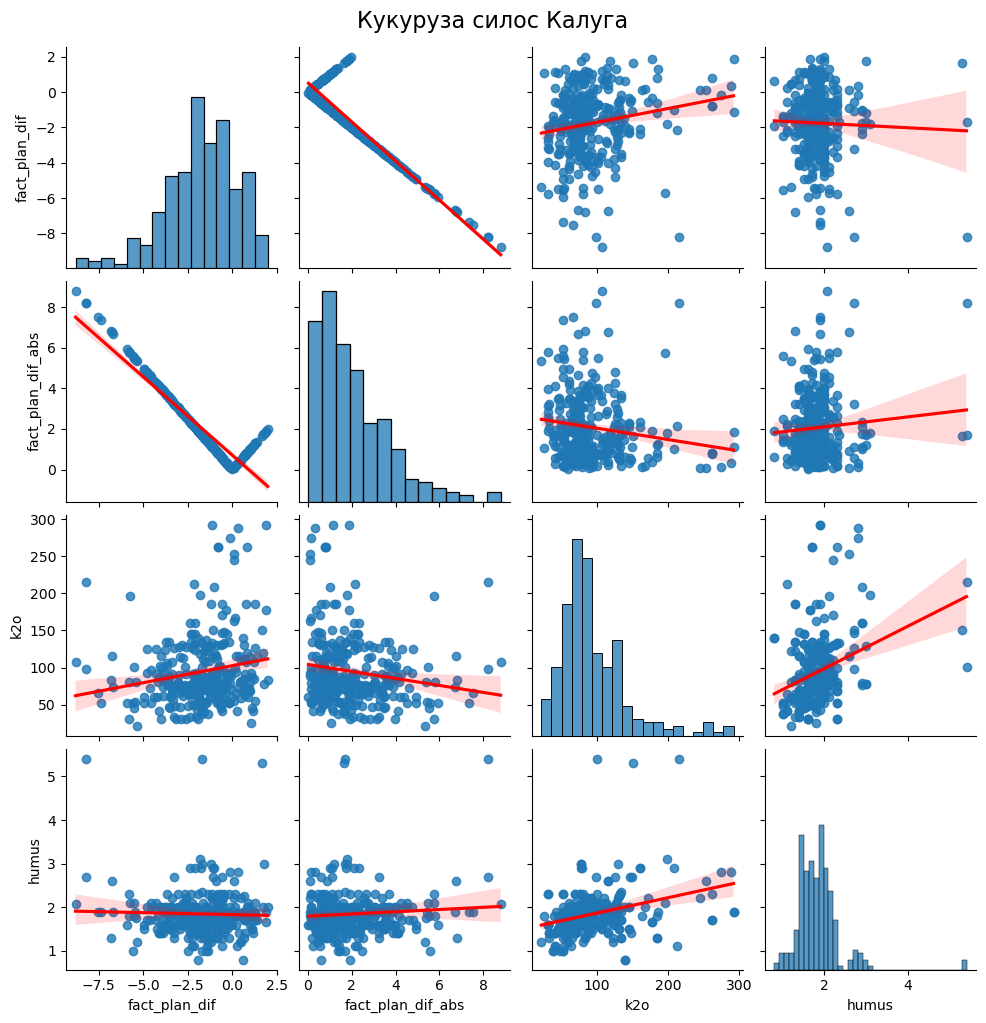

<Figure size 1000x600 with 0 Axes>

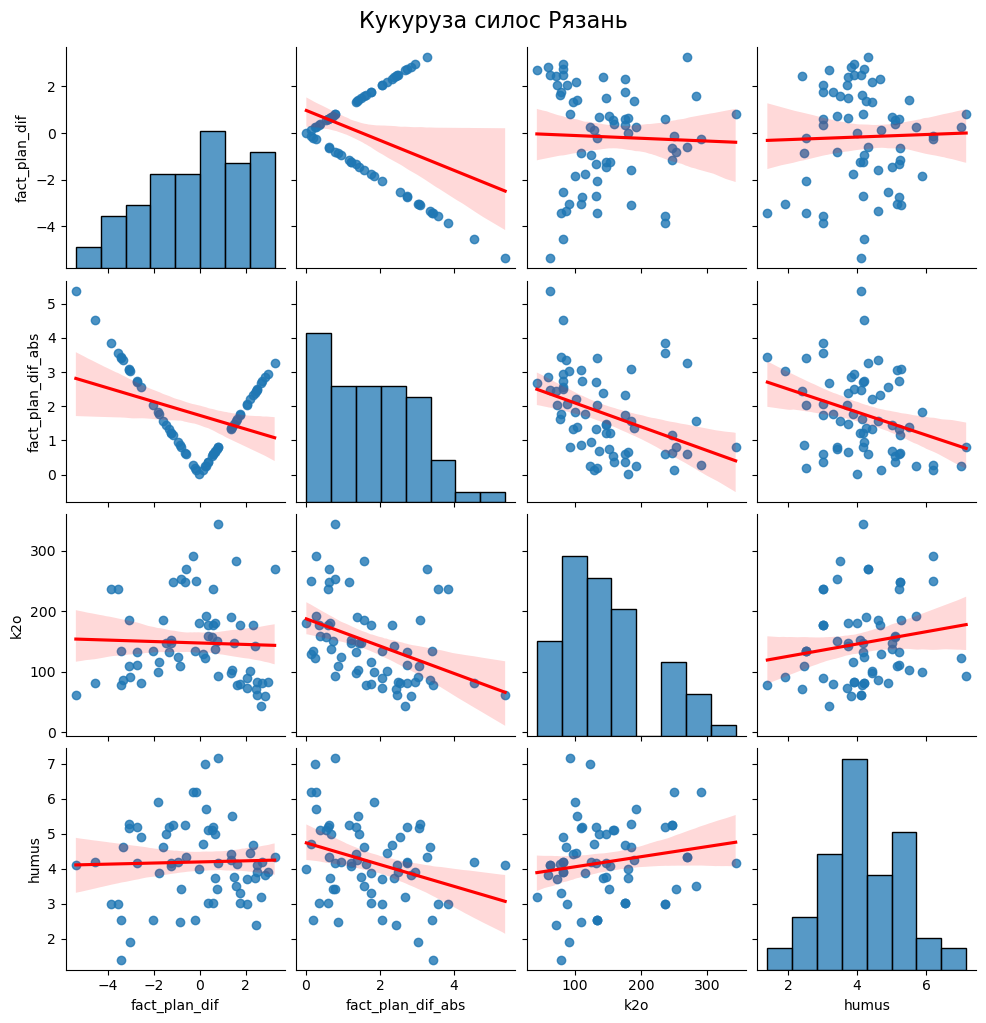

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

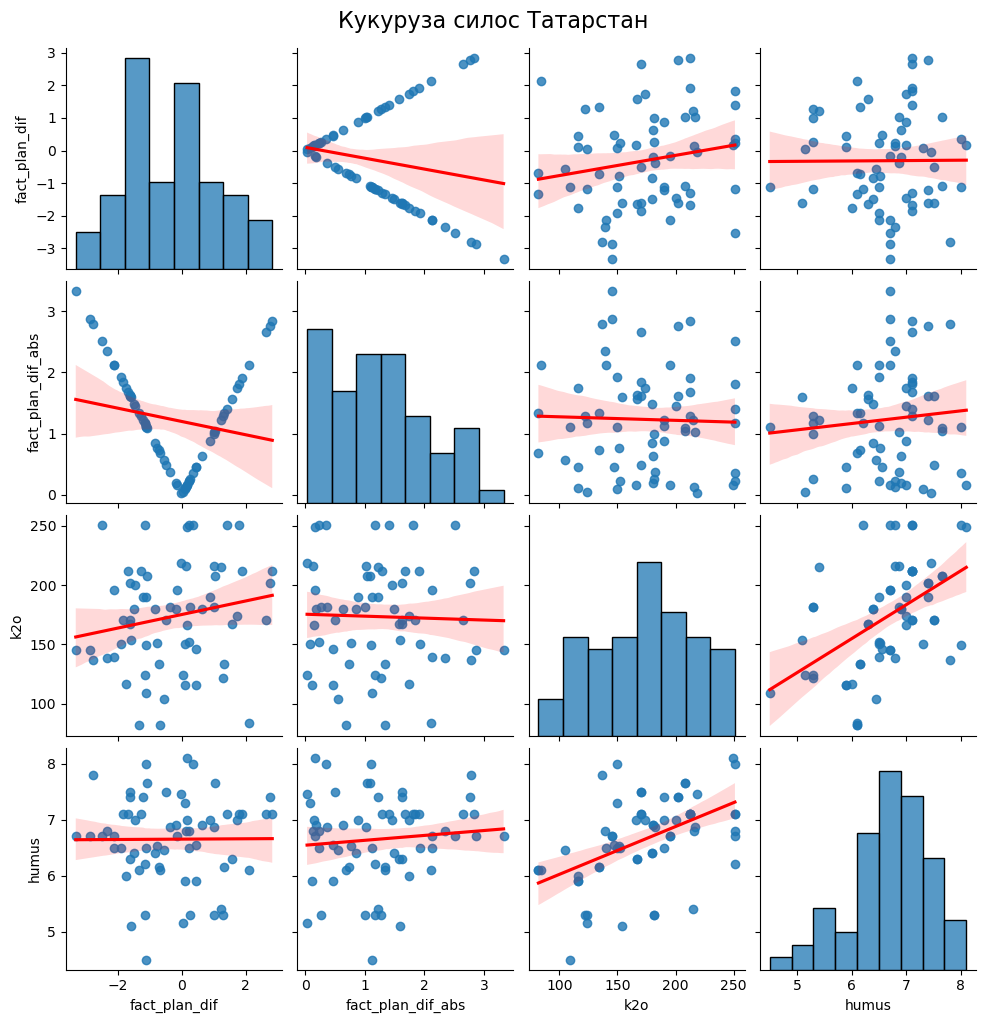

<Figure size 1000x600 with 0 Axes>

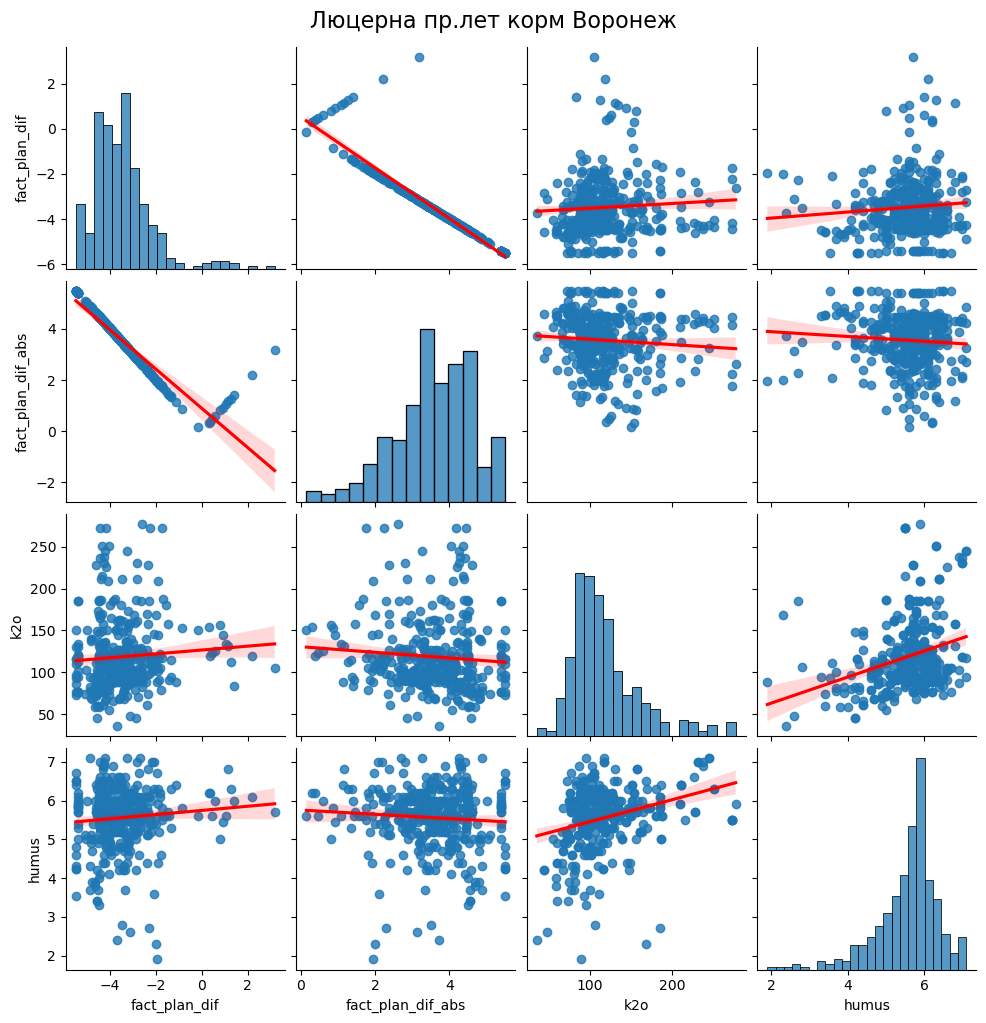

<Figure size 1000x600 with 0 Axes>

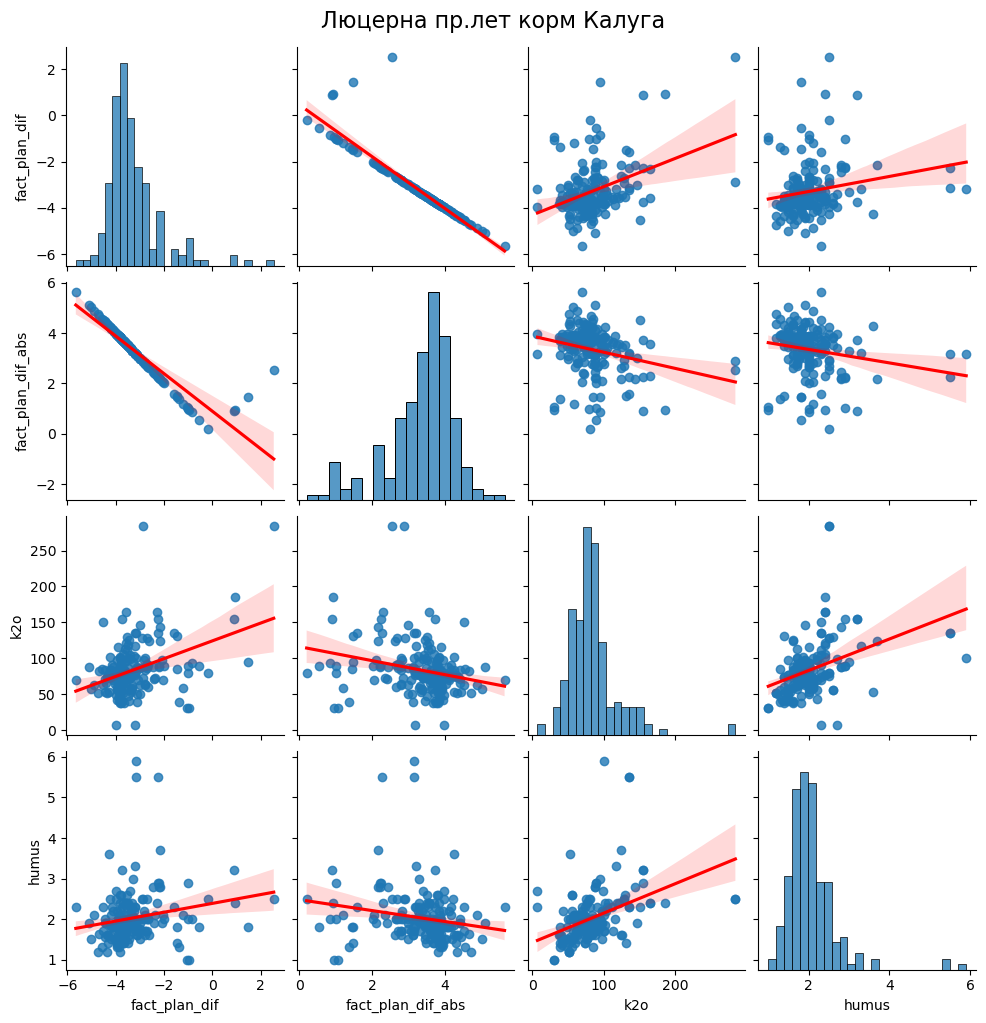

<Figure size 1000x600 with 0 Axes>

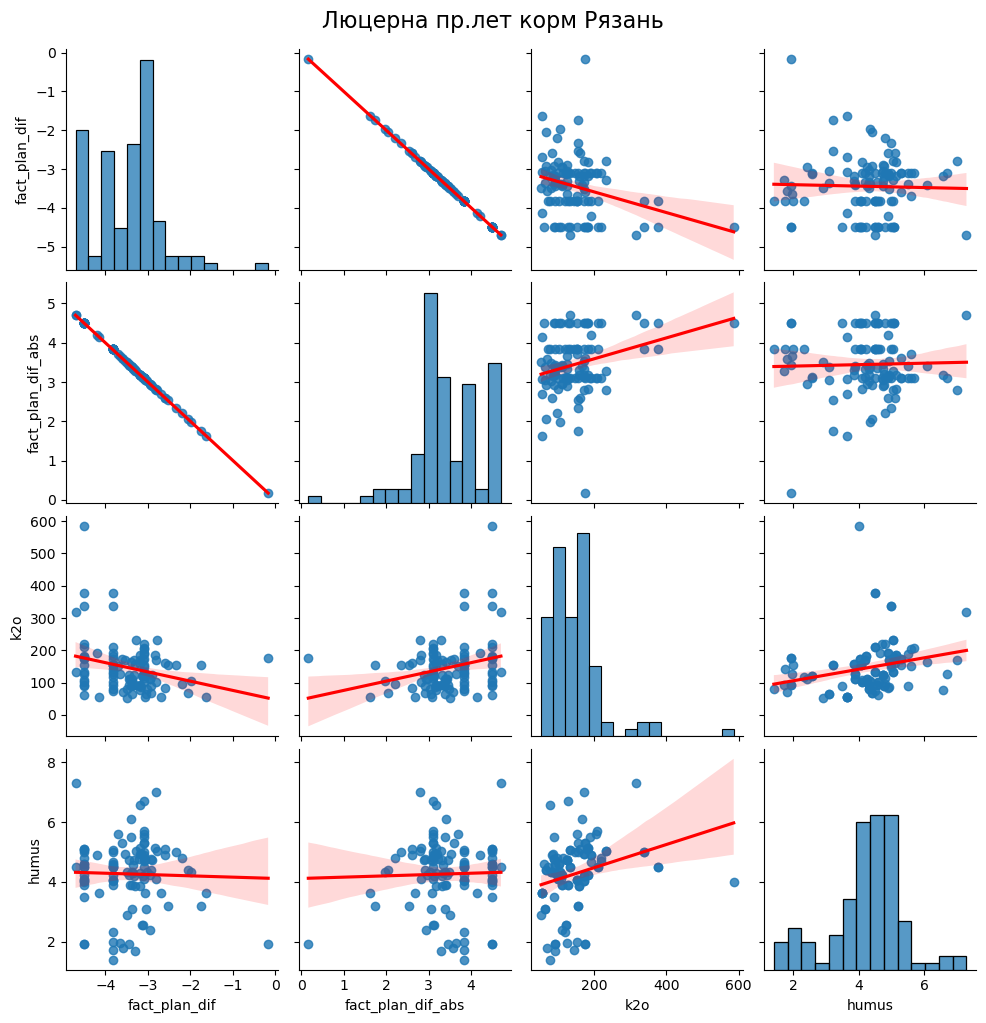

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

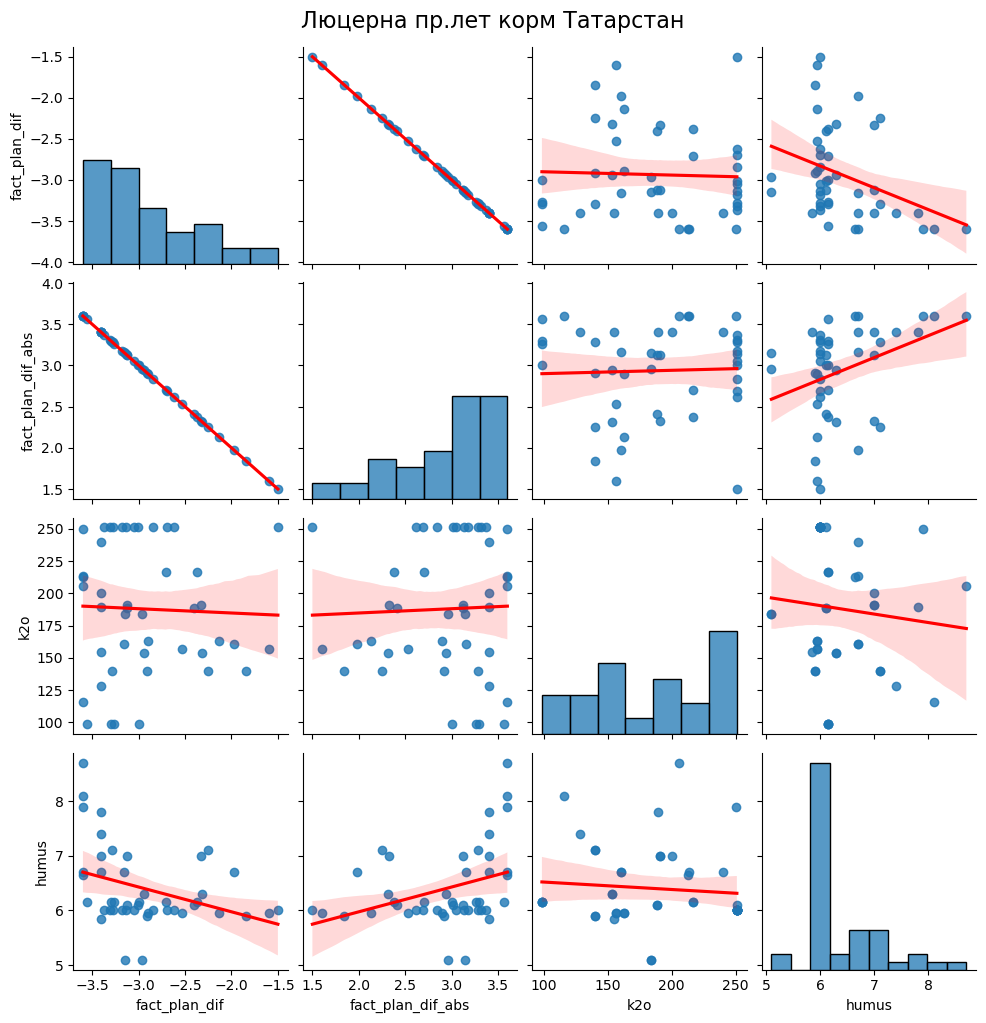

<Figure size 1000x600 with 0 Axes>

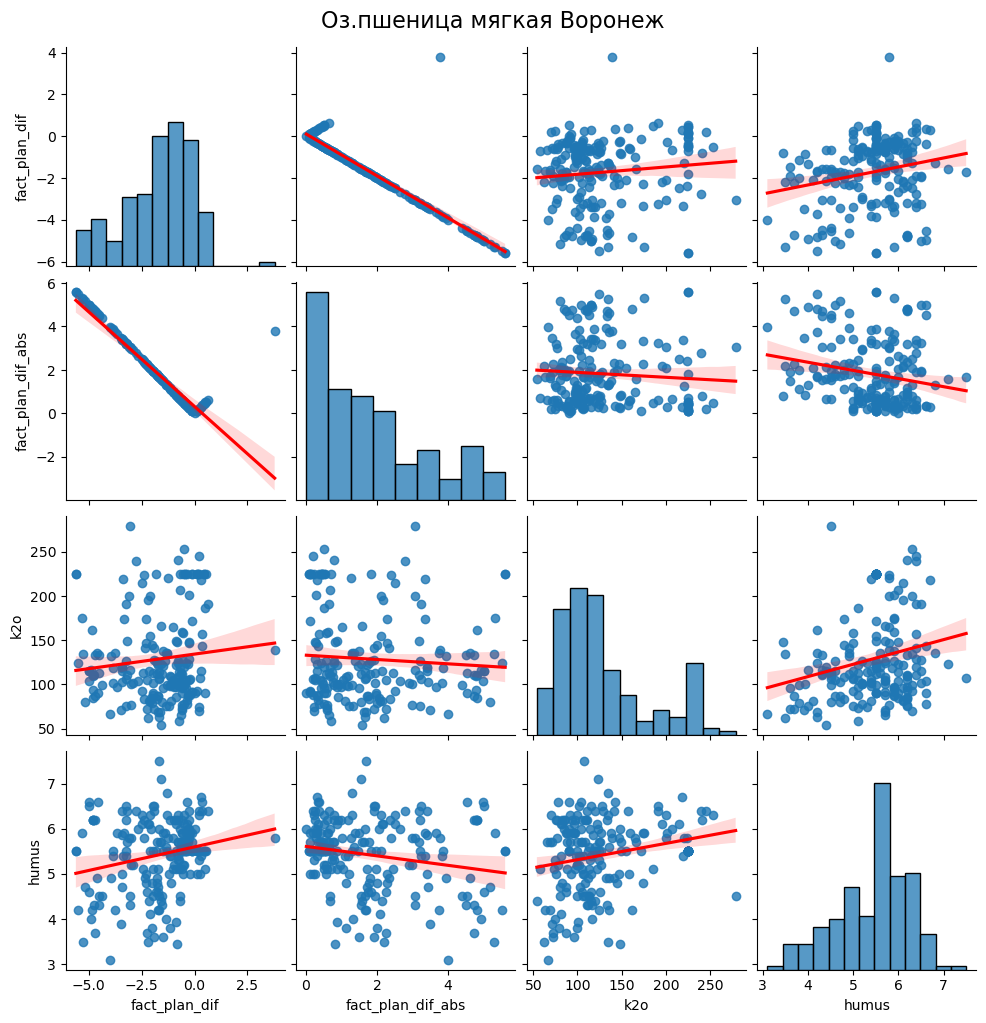

<Figure size 1000x600 with 0 Axes>

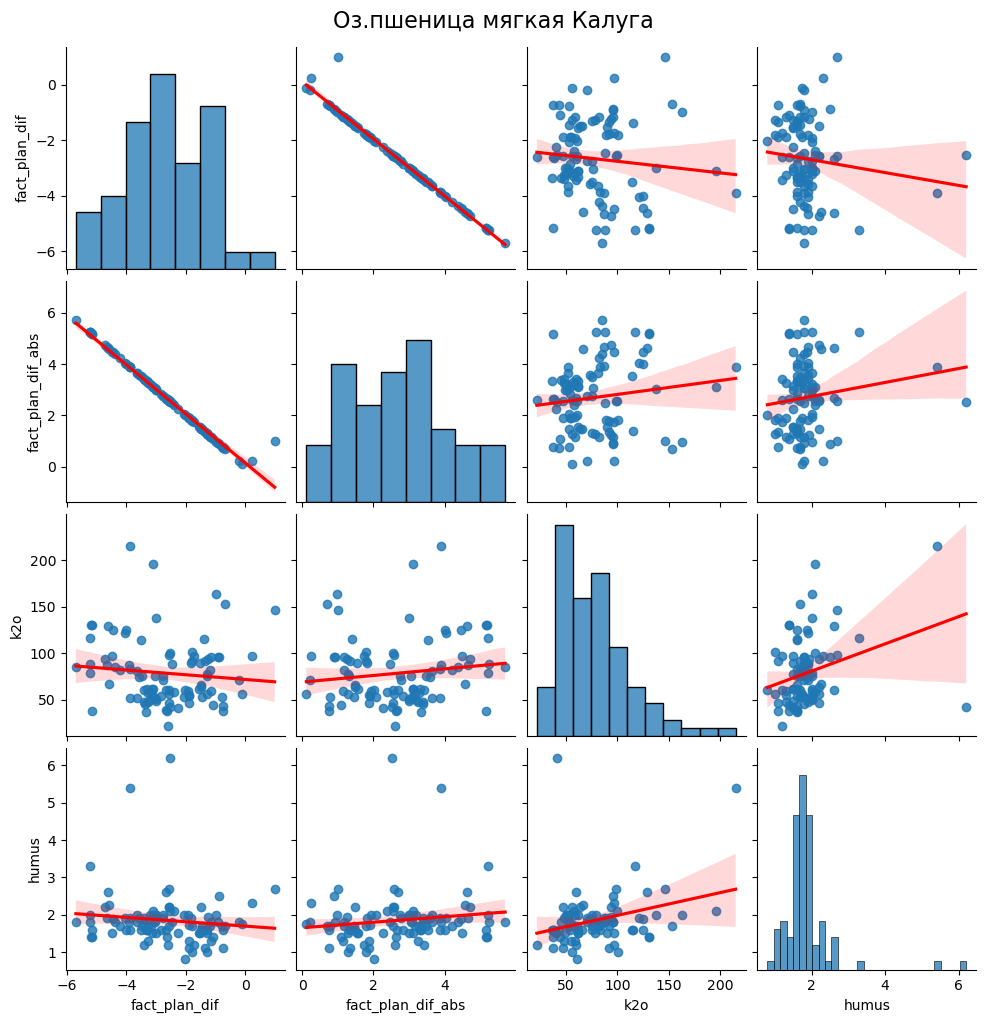

<Figure size 1000x600 with 0 Axes>

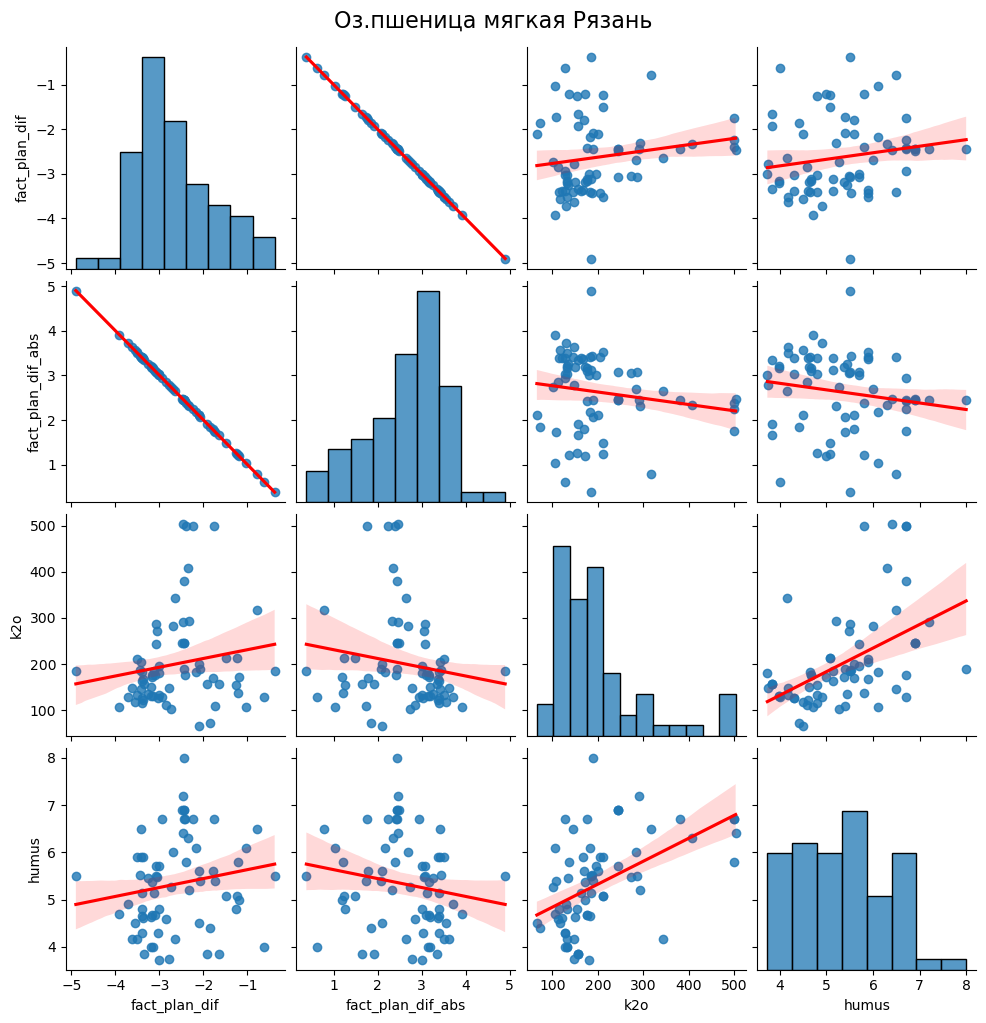

<Figure size 1000x600 with 0 Axes>

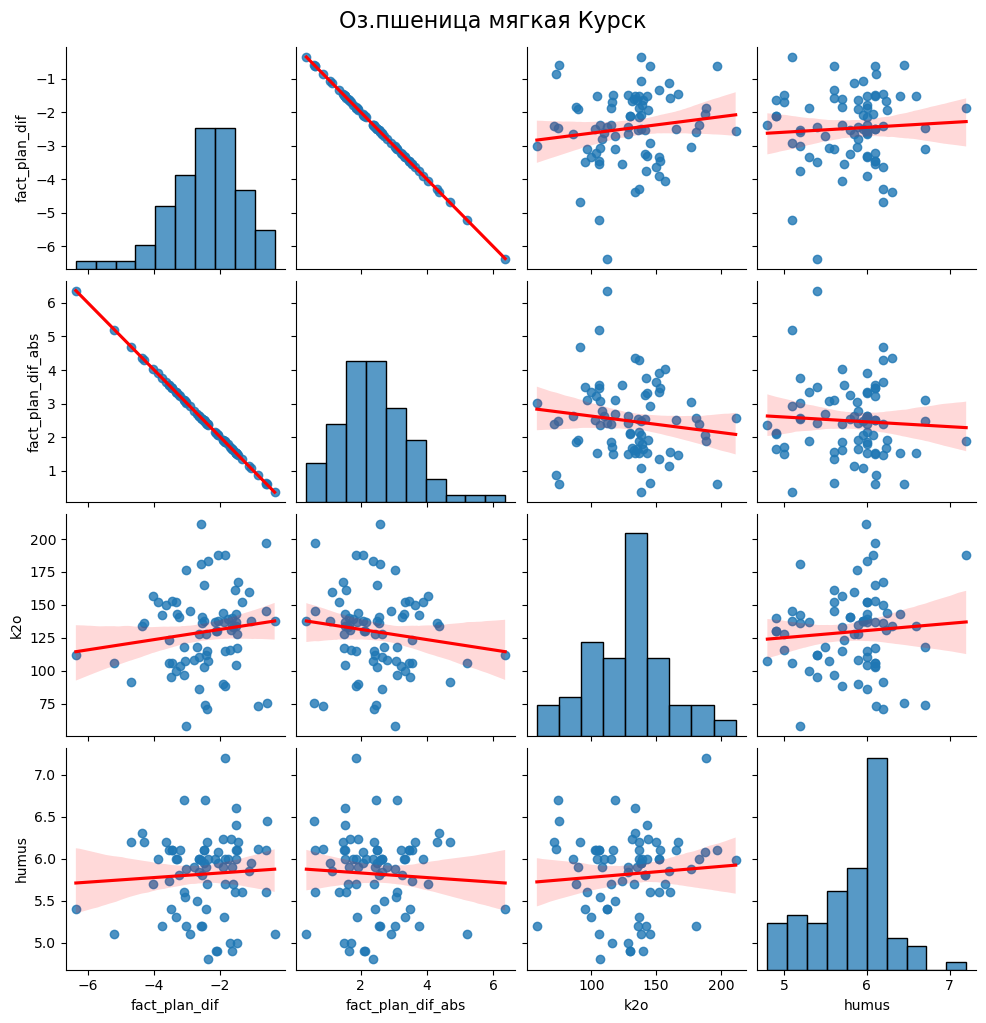

<Figure size 1000x600 with 0 Axes>

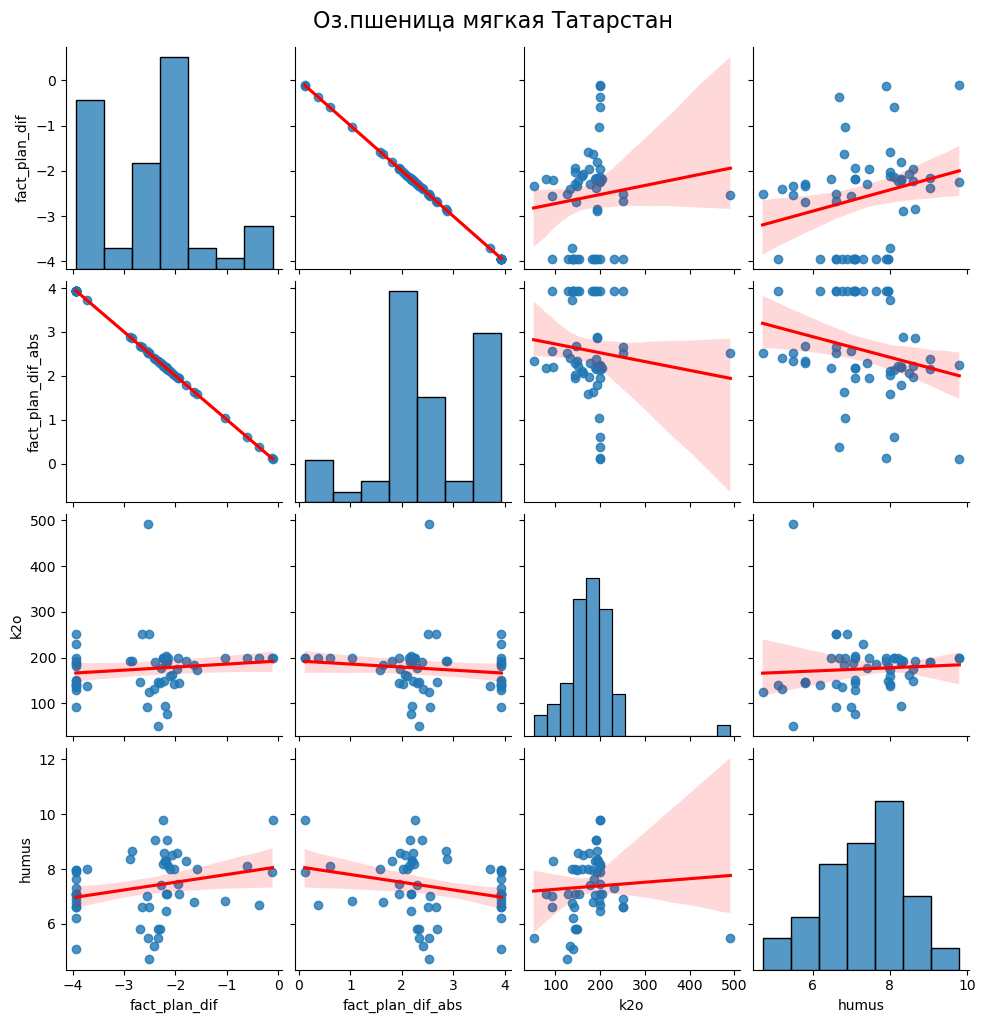

<Figure size 1000x600 with 0 Axes>

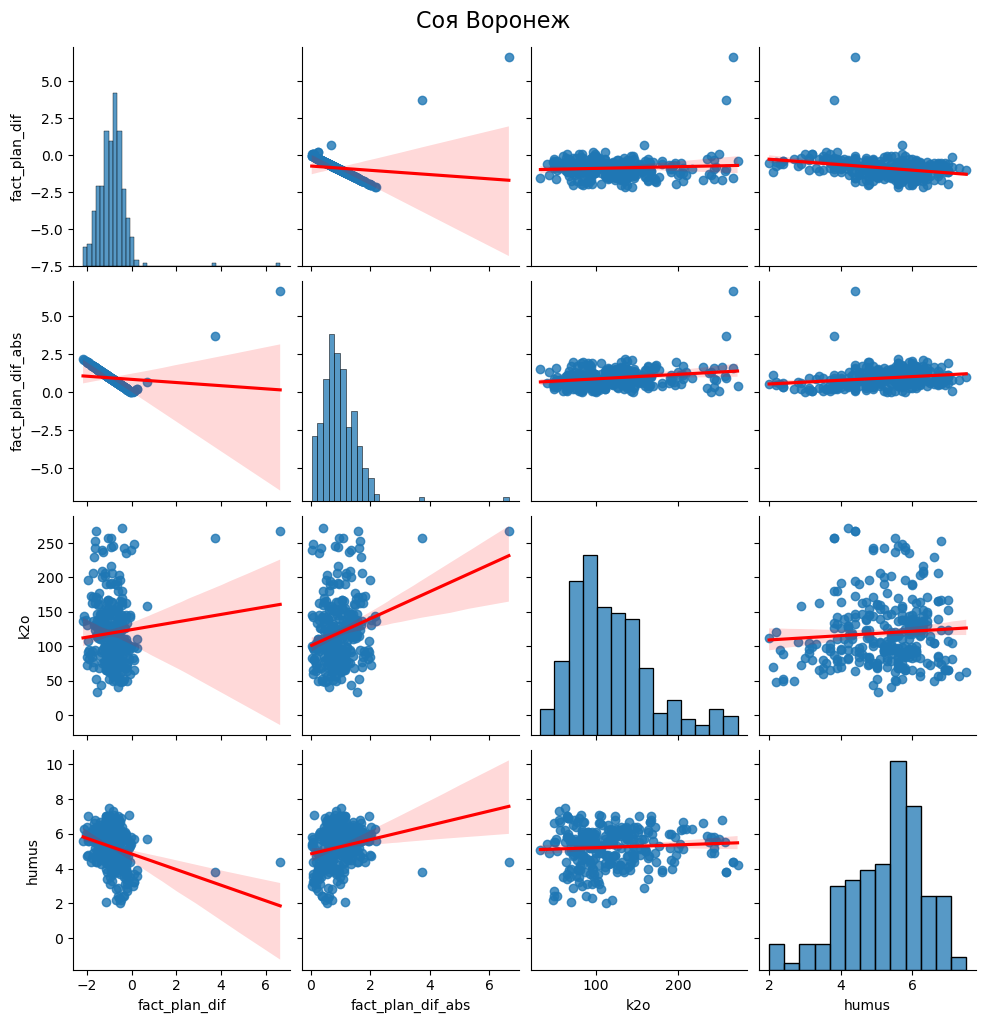

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

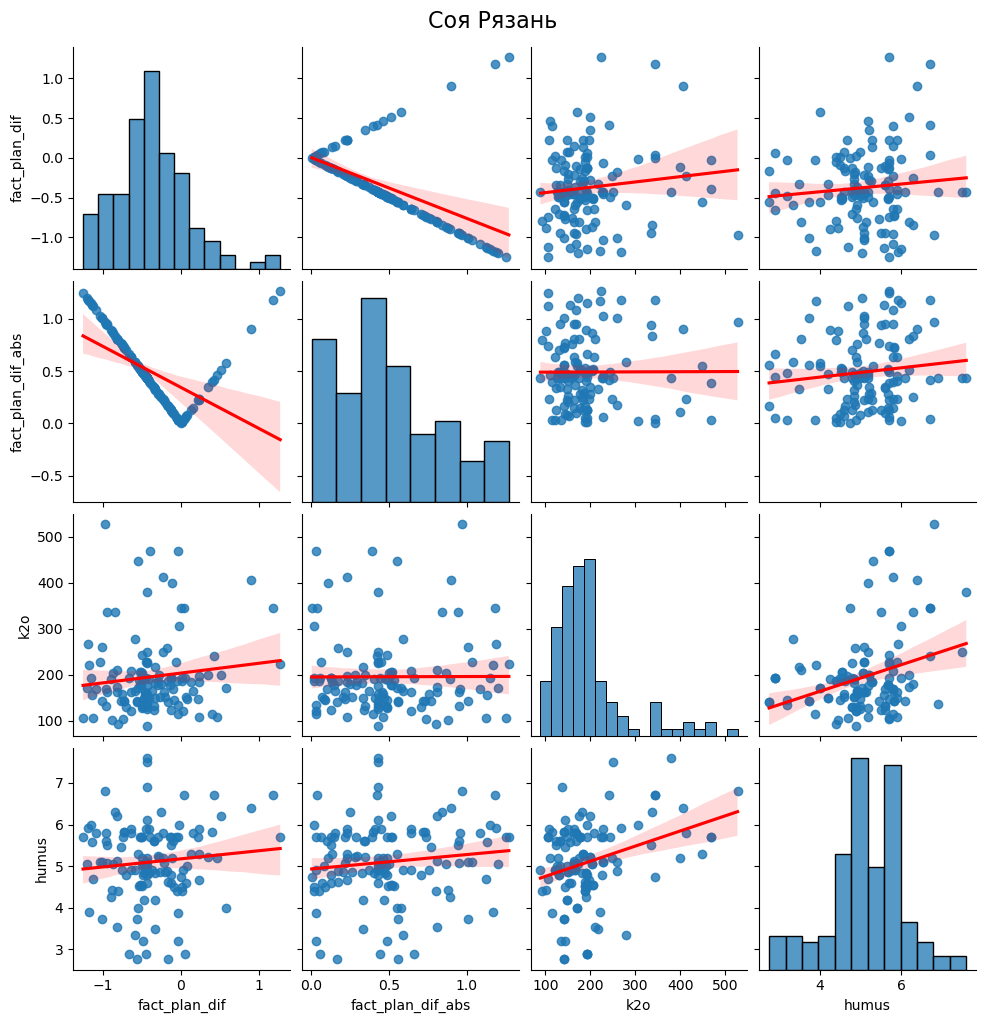

<Figure size 1000x600 with 0 Axes>

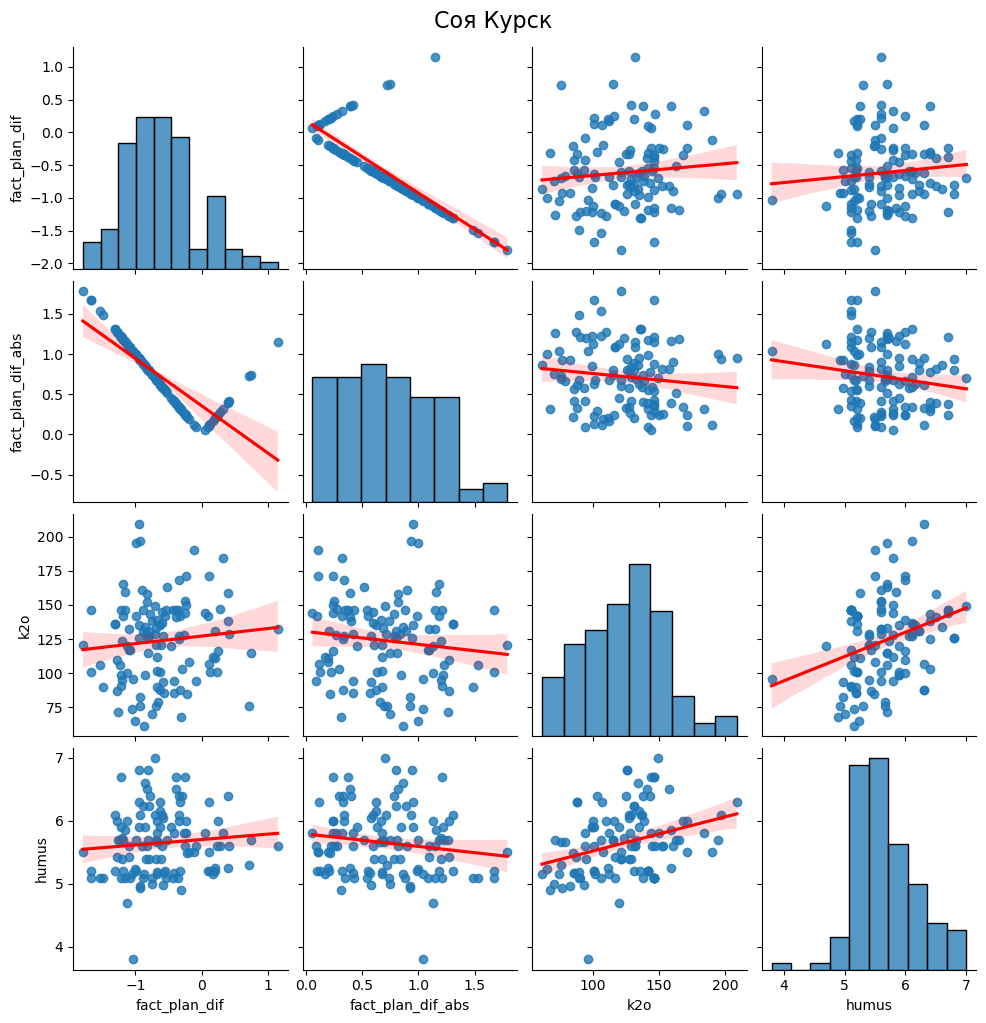

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

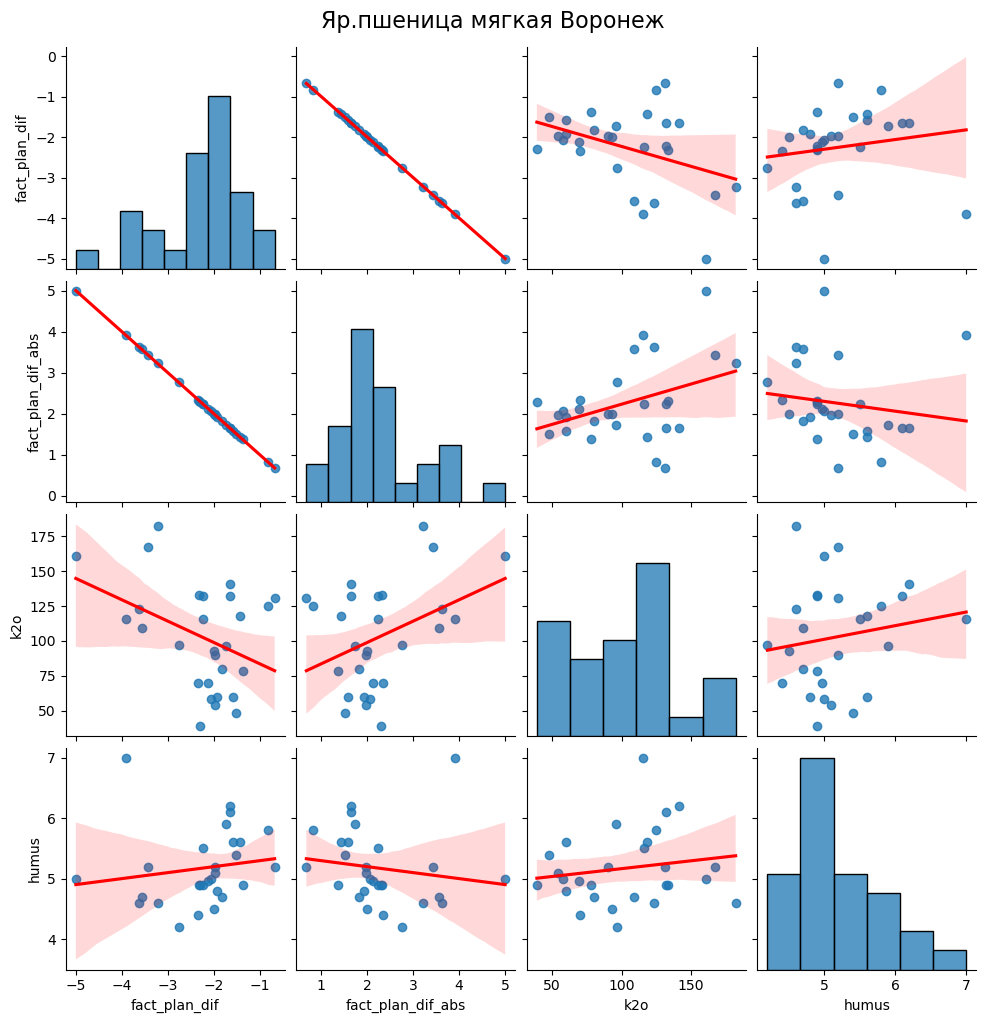

<Figure size 1000x600 with 0 Axes>

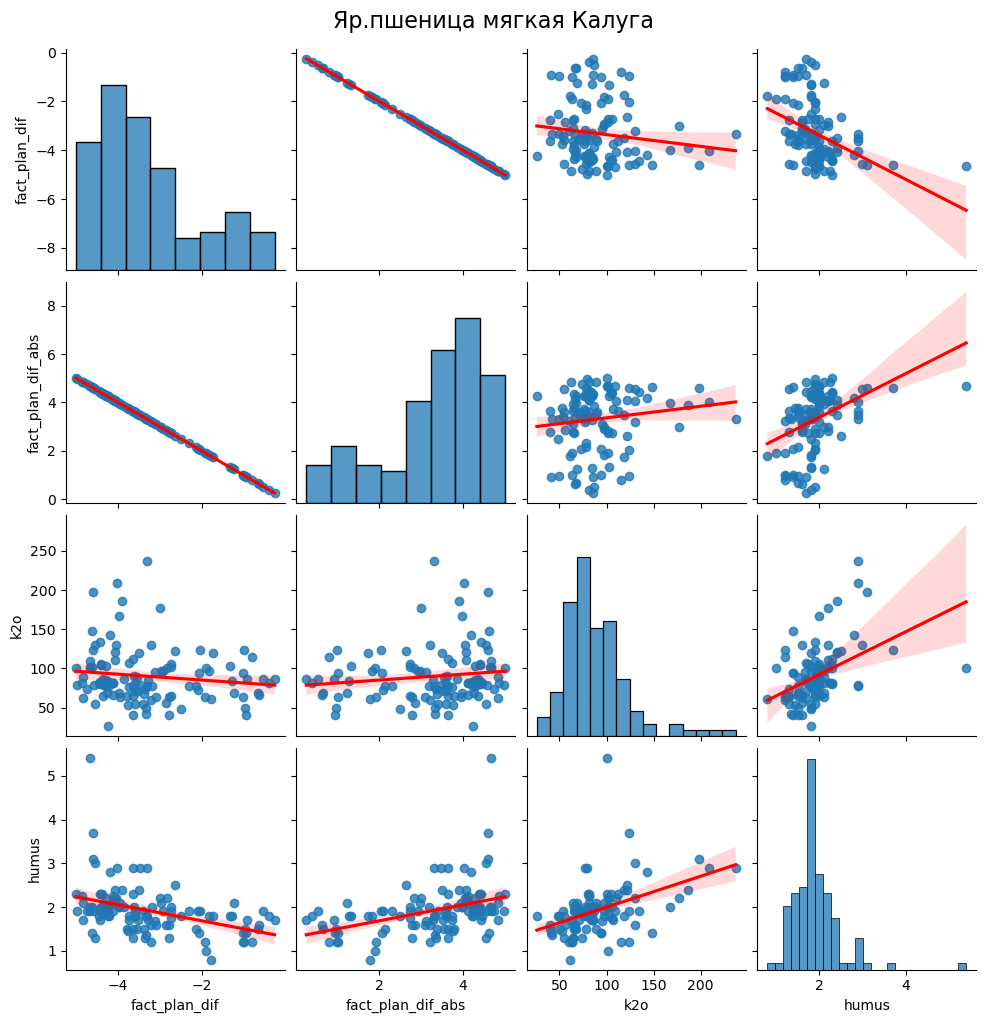

<Figure size 1000x600 with 0 Axes>

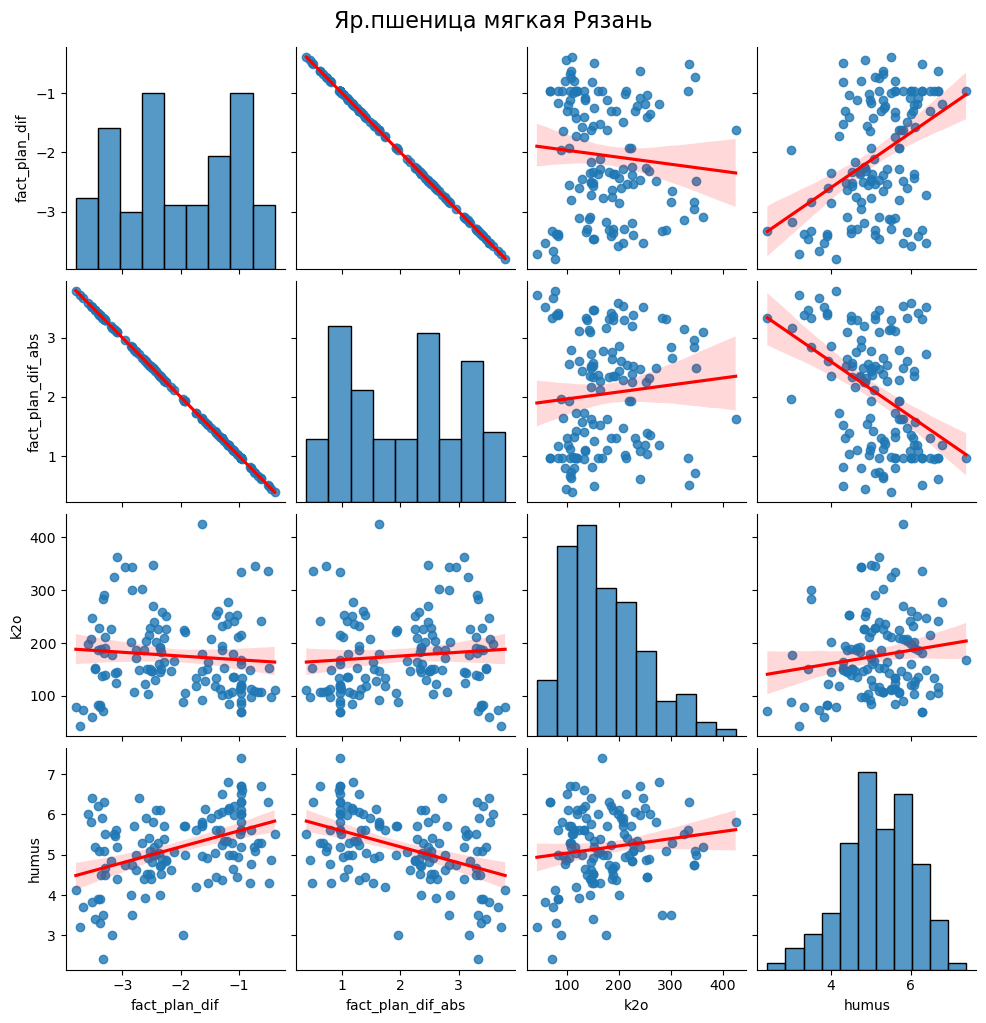

<Figure size 1000x600 with 0 Axes>

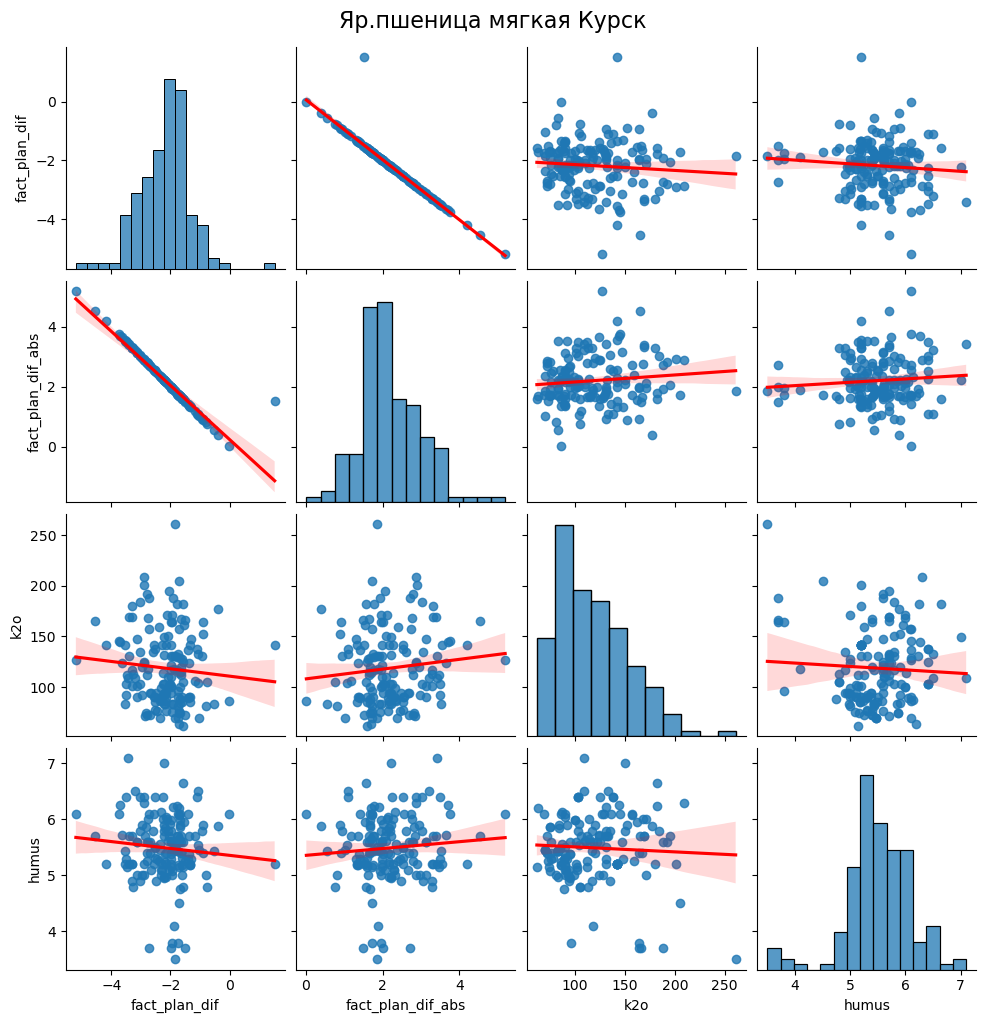

In [28]:
for crop in top_crops:
    for region in top_regions:
        plt.figure(figsize=(10, 6))

        df_crop_region = df.query(f"crop == '{crop}' and region == '{region}'")

        if (df_crop_region.shape[0] == 0):
            continue

        sns.pairplot(
            data=df_crop_region,
            vars=['fact_plan_dif', 'fact_plan_dif_abs', 'k2o', 'humus'],
            kind='reg',
            plot_kws={'line_kws':{'color':'red'}})
        
        plt.suptitle(f'{crop} {region}', y=1.02, fontsize=16)

        plt.show()

plt.close()